In [1]:
# %% Modules
from haversine import haversine as hs
from scipy.spatial.distance import euclidean as euclidean
import pyproj
from shapely.geometry import Point, LineString
import time
import copy
import osmnx as ox
from datetime import datetime
import geopandas as gpd
import networkx as nx
import momepy as mp
from collections import defaultdict
import matplotlib.pyplot as plt

import pickle


In [2]:
# %% Version check
#Checking that version 1.9.4 is installed. Newer versions cannot run this code as some have depreciated
ox.__version__

'1.9.4'

## Data

In [105]:
# Your nested dictionary
ngapipi_data = {
    'track_id': {
        'filter_xy_tuple': [
            (174.806185, -36.8544478),
            (174.8057418, -36.8534923),
            (174.8081937, -36.8546722),
            (174.8080265, -36.8546695),
            (174.8056251, -36.8534743),
            (174.8085576, -36.8548201),
            (174.8076604, -36.8547636),
            (174.8067372, -36.8546838)
           
        ],
        'match_xy_tuple': [
            (174.806265, -36.854377), 
            (174.805709, -36.853532), 
            (174.808194, -36.854672), 
            (174.808027, -36.85467), 
            (174.805737, -36.853547), 
            (174.808558, -36.85482), 
            (174.80766, -36.854764), 
            (174.806737, -36.854684)
        ],
        'match_geometry': [
            Point((174.806, -36.854)), 
            Point((174.806, -36.854)), 
            Point((174.808, -36.855)),
            Point((174.808, -36.855)),
            Point((174.806, -36.854)),
            Point((174.809, -36.855)),
            Point((174.808, -36.855)),
            Point((174.807, -36.855))
        ],
        'match_roadname': [
            'Ngapipi Road', '', 'Ngapipi Road', 'Ngapipi Road', 'Ngapipi Road', 'Ngapipi Road', 'Ngapipi Road', 'Ngapipi Road'
        ],
        'match_distance': [10.62806, 5.325484, 0, 0, 12.858593, 0, 0, 0]
    }
}

list_data = [(174.806265, -36.854377), 
            (174.805709, -36.853532), 
            (174.808194, -36.854672), 
            (174.808027, -36.85467), 
            (174.805737, -36.853547), 
            (174.808558, -36.85482), 
            (174.80766, -36.854764), 
            (174.806737, -36.854684)]

# Extract the data from the nested dictionary
df_ngapipi_data = {
    'filter_xy': ngapipi_data['track_id']['filter_xy_tuple'],
    'match_xy': ngapipi_data['track_id']['match_xy_tuple'],
    'match_geometry': ngapipi_data['track_id']['match_geometry'],
    'match_roadname': ngapipi_data['track_id']['match_roadname'],
    'match_distance': ngapipi_data['track_id']['match_distance']
}

# Convert to a GeoDataFrame
ngapipi_gdf = gpd.GeoDataFrame(df_ngapipi_data, geometry=df_ngapipi_data['match_geometry'])

# Set the CRS (WGS 84)
ngapipi_gdf.set_crs(epsg=4326, inplace=True)

# Display the GeoDataFrame
print(ngapipi_gdf)


                    filter_xy                  match_xy  \
0   (174.806185, -36.8544478)  (174.806265, -36.854377)   
1  (174.8057418, -36.8534923)  (174.805709, -36.853532)   
2  (174.8081937, -36.8546722)  (174.808194, -36.854672)   
3  (174.8080265, -36.8546695)   (174.808027, -36.85467)   
4  (174.8056251, -36.8534743)  (174.805737, -36.853547)   
5  (174.8085576, -36.8548201)   (174.808558, -36.85482)   
6  (174.8076604, -36.8547636)   (174.80766, -36.854764)   
7  (174.8067372, -36.8546838)  (174.806737, -36.854684)   

            match_geometry match_roadname  match_distance  \
0  POINT (174.806 -36.854)   Ngapipi Road       10.628060   
1  POINT (174.806 -36.854)                       5.325484   
2  POINT (174.808 -36.855)   Ngapipi Road        0.000000   
3  POINT (174.808 -36.855)   Ngapipi Road        0.000000   
4  POINT (174.806 -36.854)   Ngapipi Road       12.858593   
5  POINT (174.809 -36.855)   Ngapipi Road        0.000000   
6  POINT (174.808 -36.855)   Ngapipi Road

/var/folders/6b/r5wb08fs0n1ddq3n210r8zzr0000gn/T/ipykernel_10871/667596379.py:14: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  osm_graph = ox.graph_from_bbox(north=bbox['max_y'],
/var/folders/6b/r5wb08fs0n1ddq3n210r8zzr0000gn/T/ipykernel_10871/667596379.py:14: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  osm_graph = ox.graph_from_bbox(north=bbox['max_y'],


Downloaded OSM graph in 5.3s


/var/folders/6b/r5wb08fs0n1ddq3n210r8zzr0000gn/T/ipykernel_10871/667596379.py:31: FutureWarning: The `get_undirected` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_undirected` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  osm_graph = ox.get_undirected(osm_graph)


Graph nodes: 225, edges: 309
Graph saved to osm_graph.graphml


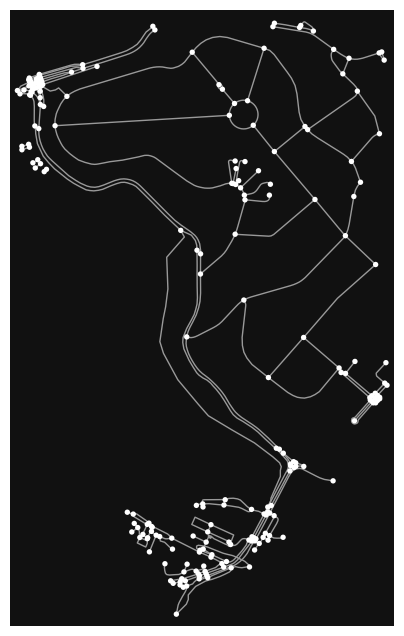

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [107]:
# %% OSMDownloader
#ORIGINAL CODE FROM SOPHIE - Testing on small part of auckland
def OSMDownloader(bbox:dict, filter:str='', retain_all:bool=True, simplify:bool=False, debug:bool=False, 
                    log_file:str='/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot/troubleshoot.csv',
                    useful_way_tags:list=ox.settings.useful_tags_way, return_directed:bool=False):
    if debug: 
        start = time.time()

    # TEST THIS
    ox.settings.useful_tags_way = useful_way_tags
    #ox.config(useful_tags_way=useful_way_tags)
    
    # will use osm graphs for now. can be converted to gdf. retains road name
    osm_graph = ox.graph_from_bbox(north=bbox['max_y'],
        south=bbox['min_y'], east=bbox['max_x'], west=bbox['min_x'],
        custom_filter=filter, retain_all=retain_all, simplify=simplify)

    if debug:
        print(f'Downloaded OSM graph in {round(time.time() - start, 1)}s')

    # save graph info for future reference
    now = datetime.now()
    min_x, min_y, max_x, max_y, name = bbox['min_x'], bbox['min_y'], bbox['max_x'], bbox['max_y'], bbox['name']
    csv_row = (f'\n{datetime.now()},{name},{min_x},{min_y},{max_x},'
                f'{max_y},{len(osm_graph.nodes)},{len(osm_graph.edges)},')
    with open(log_file, 'a') as fd:
        fd.write(csv_row)

    # I think we always want undirected, but here just in case
    if not return_directed:
        osm_graph = ox.get_undirected(osm_graph)
    
    return osm_graph

# Example bounding box for bike ride - city to Hobson Bay (need to change to all of Auckland later)
bbox = {
    'min_x': 174.803993,  # Minimum longitude
    'min_y': -36.864786,  # Minimum latitude
    'max_x': 174.815472,  # Maximum longitude
    'max_y': -36.851126,  # Maximum latitude
    'name': 'Ngapipi' # Name of the area
}

ox.settings.cache_folder = '/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot'
# Call the OSMDownloader function
osm_graph = OSMDownloader(
    bbox=bbox,
    filter="['highway']",  # You can adjust the filter as needed
    retain_all=True,
    simplify=True,
    debug=True,
    log_file='/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot/troubleshoot.csv',
    return_directed=False
)

# Print graph statistics
print(f"Graph nodes: {len(osm_graph.nodes)}, edges: {len(osm_graph.edges)}")

# Save the graph to a file
ox.save_graphml(osm_graph, filepath='/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot/troubleshoot_NGAPIPI.graphml')
print("Graph saved to osm_graph.graphml")

ox.plot_graph(osm_graph)

In [108]:
# %%  XY Tuples to Points IS THIS SUPPOSED TO BE MAPMATCHED POINTS????
# creates a list of Shapely Point objects from a list of xytuples
def XYsToPoints(xy_tuples:list):
    point_list = []
    for x, y in xy_tuples:
        point_list.append(Point(x, y))
    return point_list


import pandas as pd
#data = pd.read_csv("/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot/ngapipi_matched_xy_r50.csv")
#data = data.set_index('LONGITUDE')
#df = data.drop(columns=["Unnamed: 0"]).reset_index(drop=True)
#df.head()
# Convert DataFrame to a list of lists (rows)
#data_list = df[["matched_longitude", "matched_latitude"]].values.tolist()




#converting the tupules to poin##ts by calling the XYsToPoints function
node_tuples = XYsToPoints(xy_tuples= list_data)

print(node_tuples)
#type(node_tuples) = LIST

[<POINT (174.806 -36.854)>, <POINT (174.806 -36.854)>, <POINT (174.808 -36.855)>, <POINT (174.808 -36.855)>, <POINT (174.806 -36.854)>, <POINT (174.809 -36.855)>, <POINT (174.808 -36.855)>, <POINT (174.807 -36.855)>]


In [109]:
node_tuples

[<POINT (174.806 -36.854)>,
 <POINT (174.806 -36.854)>,
 <POINT (174.808 -36.855)>,
 <POINT (174.808 -36.855)>,
 <POINT (174.806 -36.854)>,
 <POINT (174.809 -36.855)>,
 <POINT (174.808 -36.855)>,
 <POINT (174.807 -36.855)>]

In [110]:
# %% Distances From XY List
# calculates haversine distances from previous to current point in a list of tuples
def DistancesFromXYList(xy_tuples:list, distance_args:dict, first_val:any=0):
    distances = [first_val]

    for previous, current in zip(xy_tuples, xy_tuples[1:]):
        #distance = hs((previous[1], previous[0]), (current[1], current[0]), unit=unit)
        distance = DistanceBetweenXYPairs(previous, current, distance_args)
        distances.append(round(distance, distance_args['decimals']))

    return distances

# Distance Between XY Pairs
# calculate distance between two xy points, giving projected or haversine option
def DistanceBetweenXYPairs(xy1:tuple, xy2:tuple, distance_args:dict):

    if distance_args['method'] == 'hs':
        # remember haversine input is order y, x
        dist = hs((xy1[1], xy1[0]), (xy2[1], xy2[0]), unit=distance_args['unit'])

    elif distance_args['method'] == 'proj':
        p = pyproj.Proj(distance_args['epsg'])

        xy1 = p(xy1[0], xy1[1])
        xy2 = p(xy2[0], xy2[1])

        # unit will be whatever the proj unit is
        dist = euclidean(xy1, xy2)
    
    return round(dist, distance_args['decimals'])

distance_args_defined = { #following the structure from config.yml
    "unit": "m",
    "method": "hs",
    "decimals": 2} # don't put speech marks around 2 or it will be interpreted as a string and the round function will not function

haversine_distances = DistancesFromXYList(xy_tuples=list_data, distance_args= distance_args_defined)

#print(haversine_distances)
#type(haversine_distances) = list

# CREATE GRAPH OF HAVERSINE_DISTANCES

In [111]:
# %% Add Midpoints From Cutoff
# creates new xy tuples between points that have a distance greater than a specified cutoff

# Assuming that src_distances are the distances between points

def AddMidPointsFromCutoff(src_distances:list, src_xytuples:list, cutoff:int):
    
    output_xytuples = []

    for index, distance in enumerate(src_distances):
        # calculate midpoint if distance between points is greater than cutoff
        if distance > cutoff:
            cur_geom = src_xytuples[index]
            prv_geom = src_xytuples[index - 1]

            # midpoint formula (basic linear algebra)
            interpolated_x = (prv_geom[0] + cur_geom[0]) / 2
            interpolated_y = (prv_geom[1] + cur_geom[1]) / 2

            output_xytuples.append((interpolated_x, interpolated_y))

        # make sure to add back the non-interpolated points
        output_xytuples.append(src_xytuples[index])

    return output_xytuples

midpoints = AddMidPointsFromCutoff(src_distances = haversine_distances, src_xytuples = list_data, cutoff = 10)

#print(type(midpoints)) = list
#print(midpoints)


In [112]:
# %%
# Get Edge Directions
# defines analysis direction of ways in a network
#   - finds northernmost node, then calculates bearing from that node to other
#   - if bearing is positive, assign one direction, if negative assign another
def GetEdgeDirections(cur_graph:nx.MultiDiGraph, undirected:bool=True, labels:list=['A', 'B'], 
                        return_colours:bool=False, colours:list=['blue', 'green'], 
                        debug:bool=False, identifier:str='osmid'):
    
    w_graph = copy.deepcopy(cur_graph)  # never work on source graph

    if debug:
        start = time.time()
    
    geodesic = pyproj.Geod(ellps='WGS84')  # used for bearing calculation

    # needs testing on both. default to be undirected
    if undirected:
        w_graph = w_graph.to_undirected()

    nodes = w_graph.nodes(data=True)
    way_id = 0  # simple enumeration for way id
    label_colours = []  # colours are useful when opening in a GIS for rule-based styles

    # iterate over edges with data. apply changes directly to data dict of graph
    for u, v, data in w_graph.edges(data=True):
        # save xy values for u and v nodes of way
        u_x, u_y = nodes[u]['x'], nodes[u]['y']
        v_x, v_y = nodes[v]['x'], nodes[v]['y']

        # get northernmost node simply by the highest u latitude value
        #   then calculate bearing to figure out direction
        if u_y > v_y:
            north_node = 'u'
            fwd_azimuth, bwd_azimuth, dist = geodesic.inv(u_x, u_y, v_x, v_y)
        else:  # both if v < u AND if u = v
            north_node = 'v'
            fwd_azimuth, bwd_azimuth, dist = geodesic.inv(v_x, v_y, u_x, u_y)
        
        # if the forward azimuth is positive, set to direction A, otherwise B
        if int(fwd_azimuth) > 0:
            direction = 'A'
            label_colours.append(colours[0])
        else:
            direction = 'B'
            label_colours.append(colours[1])

        data['north_node'] = north_node
        data['bearing'] = int(fwd_azimuth)
        data['direction'] = direction
        data['way_id'] = way_id if identifier == 'custom' else data['osmid']
        
        way_id += 1

    if debug:
        print(f'Calculated direction for {len(w_graph.edges)} ways in {round(time.time() - start, 1)}s')
    
    if return_colours:
        return w_graph, label_colours
    else:
        return w_graph

    
edge_directions = GetEdgeDirections(cur_graph = osm_graph, undirected = True,labels=['A','B'], return_colours = False, colours = ['blue', 'green'], debug = True)
print(edge_directions)
type(edge_directions)

Calculated direction for 309 ways in 0.1s
MultiGraph with 225 nodes and 309 edges


networkx.classes.multigraph.MultiGraph

In [114]:
print("Sample edge attributes:")
sample_edge = list(edge_directions.edges(data=True))[2]  # Get the first edge
print(sample_edge)

Sample edge attributes:
(25842600, 624924293, {'osmid': 1135068849, 'lanes': '3', 'ref': '6', 'name': 'Ngapipi Road', 'highway': 'secondary', 'maxspeed': '50', 'oneway': False, 'reversed': False, 'length': 59.812, 'geometry': <LINESTRING (174.806 -36.853, 174.806 -36.853, 174.806 -36.854)>, 'from': 624924293, 'to': 25842600, 'north_node': 'v', 'bearing': -176, 'direction': 'B', 'way_id': 1135068849})


In [115]:
# %% This produces an edge ID now
def SegmentEdges(cur_graph:nx.MultiDiGraph, segment_length:int, method:str, debug:bool=False, 
                    midpoint_cutoff:float=0.1, distance_args:dict={'unit':'m','method':'hs','decimals':2},
                    add_num:bool=False):

    w_graph = copy.deepcopy(cur_graph)

    # debug just prints time taken
    if debug:
        start = time.time()
    
    #graph = graph.copy()  # do this to seperate analysis from original graph
    nodes = w_graph.nodes(data=True)  # do this because its cleaner than writing it out each time u and v are accessed

    edge_id = 0  # simple numbering for identifier
    for u, v, data in w_graph.edges(data=True):
        edge_id += 1

        # save xy values for u and v nodes of way
        u_x, u_y = nodes[u]['x'], nodes[u]['y']
        v_x, v_y = nodes[v]['x'], nodes[v]['y']

        # change orientation of processing based on direction attribute
        if data['direction'] == 'A':
            x1, y1 = u_x, u_y
            x2, y2 = v_x, v_y
        elif data['direction'] == 'B':
            x1, y1 = v_x, v_y
            x2, y2 = u_x, u_y

        '''# need to create a proper order here
        x1, y1 = nodes[data['from']]['x'], nodes[data['from']]['y']
        x2, y2 = nodes[data['to']]['x'], nodes[data['to']]['y']'''

        # just keeping this for legacy purposes. I don't expect anyone to ever use midpoint
        if method == 'midpoint':
            # start with distance of 0 as we are calculating distance from previous
            way_geom = [(x1, y1), (x2, y2)]
            way_distances = DistancesFromXYList(way_geom, distance_args)  # this gives the same value as data['length'] but since I made the function might as well be consistent
            
            if not way_distances[1] < segment_length:
                while max(way_distances) > midpoint_cutoff:
                    way_geom = AddMidPointsFromCutoff(way_distances, way_geom, midpoint_cutoff)
                    way_distances = DistancesFromXYList(way_geom, distance_args)

                # assign segments based on cumulative distance between midpoints
                # segment structure: list of (x1, y1), (x2, y2), segment ID, length
                cur_seg_len = 0
                cur_seg_id = 0
                start_geom = way_geom[0]
                segments = []

                for index, distance in enumerate(way_distances):
                    cur_seg_len += distance

                    if cur_seg_len > segment_length:
                        end_geom = way_geom[index]
                        cur_seg_uid = str(edge_id) + '-' + str(cur_seg_id)
                        segment = [start_geom, end_geom, cur_seg_id, cur_seg_uid, cur_seg_len]

                        # reset segment values
                        segments.append(segment)
                        cur_seg_len = 0
                        cur_seg_id += 1
                        start_geom = end_geom
                    
                    elif index == len(way_distances) - 1:  
                        # add remainder
                        end_geom = way_geom[index]
                        cur_seg_uid = str(edge_id) + '-' + str(cur_seg_id)
                        segment = [start_geom, end_geom, cur_seg_id, cur_seg_uid, cur_seg_len]
                        segments.append(segment)
                
            else:  # if segment length is greater than length of way
                cur_seg_uid = str(edge_id) + '-' + str(0)
                segments = [[way_geom[0], way_geom[1], 0, cur_seg_uid, way_distances[1]]]
            
            # consolidate data
            data['segments'] = segments
            data['edge_id'] = edge_id
        
        elif method == 'interpolate':
            cur_seg_id = 0
            #cur_seg_uid = str(data['way_id']) + '-' + str(cur_seg_id)
            cur_seg_len = 0
            segments = []

            d = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)

            while d > segment_length:
                
                t = segment_length / d
                end_x, end_y = (((1 - t) * x1 + t * x2), ((1 - t) * y1 + t * y2))
                cur_seg_len = DistanceBetweenXYPairs((x1, y1), (end_x, end_y), distance_args)

                # save segment info
                start_geom = (x1, y1)
                end_geom = (end_x, end_y)
                cur_seg_uid = str(edge_id) + '-' + str(cur_seg_id)
                segment = [start_geom, end_geom, cur_seg_id, cur_seg_uid, cur_seg_len]
                segments.append(segment)
                
                # reset segment values
                cur_seg_id += 1
                d = DistanceBetweenXYPairs((x2, y2), (end_x, end_y), distance_args)
                x1, y1 = end_x, end_y
            
            # if remaining distance is less than the segment length
            else:
                # check if only 1 segment in edge. if not, use the end points from previous segment as start points for this segment
                if cur_seg_id != 0:
                    x1, y1 = end_x, end_y
                
                cur_seg_len = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)
                
                # save segment info
                start_geom = (x1, y1)
                end_geom = (x2, y2)
                cur_seg_uid = str(edge_id) + '-' + str(cur_seg_id)
                segment = [start_geom, end_geom, cur_seg_id, cur_seg_uid, cur_seg_len]
                segments.append(segment)
                
                # add
                cur_seg_id += 1
                
            data['segments'] = segments
            data['edge_id'] = edge_id

    if debug:
        print(f'Segmented {len(w_graph.edges)} ways at {segment_length}m in {round(time.time() - start, 1)}s')
    
    return w_graph  

segment_edges_graph = SegmentEdges(cur_graph = edge_directions, segment_length= 5, method = "interpolate", debug = True)
#5 used for segment_length this is in the config file

print(type(segment_edges_graph))
print(segment_edges_graph)

Segmented 309 ways at 5m in 0.0s
<class 'networkx.classes.multigraph.MultiGraph'>
MultiGraph with 225 nodes and 309 edges


In [116]:
print("Sample edge attributes:")
segment_edges_graph_sample_edge = list(segment_edges_graph.edges(data=True))[0]  # Get the first edge
print(segment_edges_graph_sample_edge)

Sample edge attributes:
(25842600, 7824666888, {'osmid': 838397397, 'highway': 'cycleway', 'oneway': False, 'reversed': False, 'length': 11.712, 'from': 7824666888, 'to': 25842600, 'geometry': <LINESTRING (174.806 -36.853, 174.806 -36.854)>, 'north_node': 'v', 'bearing': 124, 'direction': 'A', 'way_id': 838397397, 'segments': [[(174.8057371, -36.8535472), (174.80569068667802, -36.85352183706234), 0, '1-0', 5.0], [(174.80569068667802, -36.85352183706234), (174.8056442733561, -36.85349647412468), 1, '1-1', 5.0], [(174.8056442733561, -36.85349647412468), (174.8056284, -36.8534878), 2, '1-2', 1.71]], 'edge_id': 1})


In [117]:
type(segment_edges_graph)


networkx.classes.multigraph.MultiGraph

In [118]:
# %% AHHHH I Am confused
# Simple Assigning of Points to Segments 
# assigns points to segment based on simple spatial join
#   - this method is problematic for several reasons, see the code notes for more information
#   - input tracks as dictionaries, do conversion in the function
#   - segments input as gdf
def SimplePointsToSegs(segments_gdf:gpd.GeoDataFrame, tracks:dict, in_prefix:str='match_', debug:bool=False):

    w_tracks_dict = copy.deepcopy(tracks)

    # debug variables
    multimatch_sjoin_count = 0
    total_point_count = 0

    for track in w_tracks_dict.values():
        # create index for dealing with multiple sjoin outputs
        index = [i for i in range(0, len(track[f'{in_prefix}geometry']))]

        # convert matched geometry to gdf for sjoin operation
        #container = {'index': index, 'geometry': track[f'{in_prefix}geometry'], 'xy_tuples': track[f'{in_prefix}xy_tuple']}
        container = {'index': index, 'geometry': track[f'{in_prefix}geometry']}
        track_geom_gdf = gpd.GeoDataFrame(container, crs='EPSG:4326')

        joined = track_geom_gdf.sjoin_nearest(segments_gdf, how='left')

        if debug:
            multimatch_sjoin_count += (len(joined) - len(index))
            total_point_count += len(index)

        # remove duplicates, convert to dict, add to input dict copy
        joined_noduplicates = joined.groupby('index').first()
        joined_dict = joined_noduplicates.to_dict(orient='list')
        for col in list(segments_gdf.columns):
            track[col] = joined_dict[col].copy()

    if debug:
        return w_tracks_dict, multimatch_sjoin_count, total_point_count
    else:
        return w_tracks_dict

segments_graph_gdf = ox.convert.graph_to_gdfs(segment_edges_graph, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)

#unpickling the mapmatched tracks 
with open('/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot/ngapipi_mapmatched_r50', 'rb') as file:
    map_matched_tracks = pickle.load(file)


try:
    Points_to_segments = SimplePointsToSegs(segments_gdf=segments_graph_gdf, tracks=ngapipi_data, debug=True)
    print("Function executed successfully.")
except Exception as e:
    print(f"Error occurred: {e}")

Function executed successfully.


/Applications/anaconda3/lib/python3.12/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [119]:
type(Points_to_segments)

tuple

In [120]:
# %% Get Terminating Nodes
# Gets nodes that have a degree of 1 (and therefore represent the end of a road)
#   - can also sort by latitude
def GetTerminatingNodes(graph, return_data=False, debug=False, order_by_north=True):
    startend_points = []
    for node in graph.nodes(data=True):
        if graph.degree(node[0]) == 1:
            startend_points.append(node)

    if order_by_north:
        startend_points.sort(key=lambda x: x[1]['y'], reverse=True)

    return startend_points




# Remove Edges Without Attribute
# Removes edges that do not contain an input attribute
def RemoveEdgesWithoutAttribute(graph, attribute, debug=False, remove_isolates=True):
    w_graph = copy.deepcopy(graph)

    count_rmedges = 0
    for u, v, data in list(w_graph.edges(data=True)):
        if attribute not in data or data[attribute] == 'not available':
            w_graph.remove_edge(u, v)
            count_rmedges += 1

    isolates = list(nx.isolates(w_graph))
    count_rmnodes = len(isolates)
    w_graph.remove_nodes_from(isolates)

    if debug:
        print(f'Removed {count_rmnodes} nodes and {count_rmedges} edges for missing attribute "{attribute}"')

    return w_graph

# %% Order Segment Graph
# Assigns order to segments/graph edges based on depth-first search
def OrderSegmentGraph(cur_graph:nx.MultiDiGraph, out_attribute='seg_pos_on_way', 
                      group_attribute='name', debug=False,
                        add_numbering=False):

    w_graph = copy.deepcopy(cur_graph)
    w_graph = w_graph.to_undirected()

    if debug:
        start = time.time()
    
    # Step 1: remove ways that don't have names (and relevant nodes)
    w_graph = RemoveEdgesWithoutAttribute(w_graph, group_attribute)

    
    # Inspect the type and value of data[group_attribute]
    #for u, v, data in w_graph.edges(data=True):
     #   print(f"data[group_attribute] = {data[group_attribute]}")  # Check the value
    
    # Step 2: group ways by road name
    edges_by_road = {}
    for u, v, data in w_graph.edges(data=True):
        # Assign 'unknown' as the default value if group_attribute is missing
        group_value = data.get(group_attribute, 'unknown')
        group_value = group_value if isinstance(group_value, str) else group_value[0]

        # Add to dictionary, using group_value as the key
        if group_value in edges_by_road:
            edges_by_road[group_value].append((u, v, 0))
        else:
            edges_by_road[group_value] = [(u, v, 0)]


        

    # Step 3: obtain subgraph for grouped ways
    # .copy() means data is retained
    # have to create actual graph rather than subgraph to avoid connection issues between ways
    all_subgraphs = [nx.MultiDiGraph(w_graph.edge_subgraph(edges_by_road[name]).copy()).to_undirected() for name in edges_by_road]

    if add_numbering:
        way_num = 0
    
   # Step 4: find connected subgraphs
    from collections import defaultdict

    # Step 4: find connected subgraphs
    for subgraph in all_subgraphs:
        print(f"Subgraph edges: {list(subgraph.edges(data=True))}")

        # Filter out self-loops (edges where from node and to node are the same)
        subgraph.remove_edges_from([(u, v) for u, v in subgraph.edges() if u == v])

        if len(subgraph.edges) == 0:
            print("Subgraph has no edges.")
            continue  # Skip this subgraph or handle it appropriately

        # Proceed with the rest of the processing
        way_cons = [i for i in nx.connected_components(subgraph)]
    
    # Rest of your code...


        # Initialize a dictionary to store groups based on edge names
        name_groups = defaultdict(list)

        # for each set of connections within a subgraph
        for i, connections in enumerate(way_cons):
            if add_numbering:
                way_num += 1

            # Add custom ref attribute
            first_edge = list(subgraph.edges(data=True))[0]  # Now safe to access

            # Debugging print statement to check the structure
            print(f"First edge: {first_edge}")

            # The rest of the code remains the same...


            # Check if 'name' is a list or a single string
            if isinstance(first_edge[2], dict) and 'name' in first_edge[2]:
                edge_names = first_edge[2]['name']
                if isinstance(edge_names, list):  # If 'name' is a list, group by all names
                    custom_ref = '_'.join(edge_names) + '_' + str(i)  # Join multiple names with '_'
                else:
                    custom_ref = edge_names + '_' + str(i)
            else:
                # If it's not a dictionary or 'name' is not found, handle it differently
                print(f"Warning: Edge does not have a 'name' attribute. Using alternative custom_ref.")
                custom_ref = f"custom_ref_{i}"

            # Add the edge to the group dictionary, using the name(s) as the key
            name_groups[custom_ref].append(first_edge)

        # Now you have the edges grouped by their custom name
        print(f"Grouped edges based on names: {dict(name_groups)}")
        
        # Create graph from subgraph connections, grouped by name
        for group, edges in name_groups.items():
            # Process each group of edges (you can use 'edges' as needed)
            way_graph = nx.MultiDiGraph(subgraph.subgraph([e[0] for e in edges] + [e[1] for e in edges]).copy()).to_undirected()

            startend_points = GetTerminatingNodes(way_graph)


        # Proceed with the rest of the processing...


            #ox.plot_graph(way_graph)

            '''# if there is only one node (edge)
            if way_lgraph.number_of_nodes() == 1:
                # set output attribute to 0 (as there is only one edge to form a path to/from anyway)
                edge = list(way_lgraph.nodes())[0]
                w_graph[edge[0]][edge[1]][0][out_attribute] = 0'''

            if len(startend_points) > 0:  # if startend points are found, use the northernmost of those
                source = startend_points[0][0]
            else:  # otherwise, use the northenmost of any node in the subgraph
                northernmost_node = None
                for node in way_graph.nodes(data=True):
                    if northernmost_node == None:
                        northernmost_node = node
                    else:
                        if node[1]['y'] > northernmost_node[1]['y']:
                            northernmost_node = node
                source = node[0]
                
            # perform depth-first search along edges in graph, assign labels based on order of search
            edge_order = nx.edge_dfs(way_graph, source=source)
            edge_labels = [(edge, number) for number, edge in enumerate(edge_order)]
            for edge, number in edge_labels:
                w_graph[edge[0]][edge[1]][0][out_attribute] = number
                w_graph[edge[0]][edge[1]][0]['custom_ref'] = custom_ref

                if add_numbering:
                    w_graph[edge[0]][edge[1]][0]['way_number'] = way_num

        if len(way_cons) == 0:
            print(way_graph.edges)

    if debug:
        print(f'Ordered {len(w_graph.edges)} edges in {round(time.time() - start, 1)}s')
    
    return w_graph

Ordered_seg_graph = OrderSegmentGraph(cur_graph=segment_edges_graph)

#print(Ordered_seg_graph)

Subgraph edges: [(624924293, 25842600, {'osmid': 1135068849, 'lanes': '3', 'ref': '6', 'name': 'Ngapipi Road', 'highway': 'secondary', 'maxspeed': '50', 'oneway': False, 'reversed': False, 'length': 59.812, 'geometry': <LINESTRING (174.806 -36.853, 174.806 -36.853, 174.806 -36.854)>, 'from': 624924293, 'to': 25842600, 'north_node': 'v', 'bearing': -176, 'direction': 'B', 'way_id': 1135068849, 'segments': [[(174.8057816, -36.8530105), (174.8057778798863, -36.85305536707909), 0, '3-0', 5.0], [(174.8057778798863, -36.85305536707909), (174.80577415977262, -36.85310023415817), 1, '3-1', 5.0], [(174.80577415977262, -36.85310023415817), (174.80577043965894, -36.85314510123725), 2, '3-2', 5.0], [(174.80577043965894, -36.85314510123725), (174.80576671954523, -36.853189968316336), 3, '3-3', 5.0], [(174.80576671954523, -36.853189968316336), (174.80576299943152, -36.85323483539542), 4, '3-4', 5.0], [(174.80576299943152, -36.85323483539542), (174.80575927931784, -36.85327970247451), 5, '3-5', 5.0],

In [121]:
print(Ordered_seg_graph)
type(Ordered_seg_graph)

MultiGraph with 119 nodes and 124 edges


networkx.classes.multigraph.MultiGraph

In [122]:
print("Sample edge attributes:")
ordered_seg_sample_edge = list(Ordered_seg_graph.edges(data=True))[0]  # Get the first edge
print(ordered_seg_sample_edge)



Sample edge attributes:
(25842600, 11182250963, {'osmid': [1265987410, 815458771, 294270597], 'lanes': '2', 'ref': '6', 'name': 'Ngapipi Road', 'highway': 'secondary', 'maxspeed': '50', 'oneway': False, 'reversed': True, 'length': 568.4660000000001, 'geometry': <LINESTRING (174.81 -36.856, 174.81 -36.856, 174.81 -36.856, 174.81 -36.856,...>, 'from': 11182250963, 'to': 25842600, 'north_node': 'u', 'bearing': 127, 'direction': 'A', 'way_id': [1265987410, 815458771, 294270597], 'segments': [[(174.8057371, -36.8535472), (174.80578154257856, -36.853574720398285), 0, '2-0', 5.0], [(174.80578154257856, -36.853574720398285), (174.80582598515713, -36.85360224079657), 1, '2-1', 5.0], [(174.80582598515713, -36.85360224079657), (174.80587042773573, -36.85362976119485), 2, '2-2', 5.0], [(174.80587042773573, -36.85362976119485), (174.8059148703143, -36.85365728159314), 3, '2-3', 5.0], [(174.8059148703143, -36.85365728159314), (174.80595931289287, -36.85368480199142), 4, '2-4', 5.0], [(174.8059593128

In [123]:
#Looking into the data in ordered_seg_graph

#NODES
print("Nodes in Ordered_seg_graph:")
for node, data in Ordered_seg_graph.nodes(data=True):
    print(f"Node: {node}, Data: {data}")
    

#EDGES
print("\nEdges in Ordered_seg_graph:")
for u, v, data in Ordered_seg_graph.edges(data=True):
    print(f"Edge: {u} -> {v}, Data: {data}")
    
#SEGMENTS
print("\nSegments in Ordered_seg_graph edges:")
for u, v, data in Ordered_seg_graph.edges(data=True):
    segments = data.get('segments', [])
    print(f"Edge {u} -> {v} has {len(segments)} segments:")
    for i, seg in enumerate(segments):
        print(f"  Segment {i}: {seg}")



Nodes in Ordered_seg_graph:
Node: 25842600, Data: {'y': -36.8535472, 'x': 174.8057371, 'street_count': 3}
Node: 25842608, Data: {'y': -36.8513511, 'x': 174.808966, 'street_count': 3}
Node: 25842611, Data: {'y': -36.8512787, 'x': 174.812248, 'street_count': 3}
Node: 25842613, Data: {'y': -36.8517839, 'x': 174.8139374, 'street_count': 3}
Node: 25842621, Data: {'y': -36.8534824, 'x': 174.80619, 'street_count': 3}
Node: 25842623, Data: {'y': -36.8528291, 'x': 174.806519, 'street_count': 3}
Node: 25842630, Data: {'y': -36.8517592, 'x': 174.8120022, 'street_count': 3}
Node: 25842631, Data: {'y': -36.8525699, 'x': 174.8107481, 'street_count': 2}
Node: 25842632, Data: {'y': -36.8529879, 'x': 174.81118, 'street_count': 3}
Node: 25842633, Data: {'y': -36.8529266, 'x': 174.8115429, 'street_count': 3}
Node: 25842634, Data: {'y': -36.8534722, 'x': 174.8117013, 'street_count': 3}
Node: 25842637, Data: {'y': -36.853251, 'x': 174.8110356, 'street_count': 3}
Node: 25842647, Data: {'y': -36.8558961, 'x'

## Hackyhour

- masking a real error of not enough values expected 8 but got 5
- Attempting this code to fix

In [124]:
# Segment GeoDataFrame From Graph
# THIS ONLY WORKS ON THE SEGMENTED GRAPH, NOT THE GRAPH PRODUCED FROM SEGMENTS
# creates geodataframe of segments from a (spatially segmented) networkx graph
from tqdm.auto import tqdm

def SegGDFFromGraph(graph:nx.MultiDiGraph):
    rows = []
    for index, (u, v, data) in enumerate(tqdm(graph.edges(data=True))):
        for start_xy, end_xy, seg_id, seg_uid, length in data['segments']:
            rows.append({
                "geometry": LineString([Point(start_xy), Point(end_xy)]),
                "seg_id": seg_id,
                "seg_uid": seg_uid,
                "seg_length": length,
                "osmid": data["osmid"]
            })
    gdf = gpd.GeoDataFrame(rows, crs=4326)
    return gdf

Segment_gdf = SegGDFFromGraph(graph = Ordered_seg_graph)

  0%|          | 0/124 [00:00<?, ?it/s]

In [125]:
Segment_gdf.head(10)

,geometry,seg_id,seg_uid,seg_length,osmid
0,"LINESTRING (174.80574 -36.85355, 174.80578 -36...",0,2-0,5.0,"[1265987410, 815458771, 294270597]"
1,"LINESTRING (174.80578 -36.85357, 174.80583 -36...",1,2-1,5.0,"[1265987410, 815458771, 294270597]"
2,"LINESTRING (174.80583 -36.85360, 174.80587 -36...",2,2-2,5.0,"[1265987410, 815458771, 294270597]"
3,"LINESTRING (174.80587 -36.85363, 174.80591 -36...",3,2-3,5.0,"[1265987410, 815458771, 294270597]"
4,"LINESTRING (174.80591 -36.85366, 174.80596 -36...",4,2-4,5.0,"[1265987410, 815458771, 294270597]"
5,"LINESTRING (174.80596 -36.85368, 174.80600 -36...",5,2-5,5.0,"[1265987410, 815458771, 294270597]"
6,"LINESTRING (174.80600 -36.85371, 174.80605 -36...",6,2-6,5.0,"[1265987410, 815458771, 294270597]"
7,"LINESTRING (174.80605 -36.85374, 174.80609 -36...",7,2-7,5.0,"[1265987410, 815458771, 294270597]"
8,"LINESTRING (174.80609 -36.85377, 174.80614 -36...",8,2-8,5.0,"[1265987410, 815458771, 294270597]"
9,"LINESTRING (174.80614 -36.85379, 174.80618 -36...",9,2-9,5.0,"[1265987410, 815458771, 294270597]"


In [126]:
# Validate Segment
# Checks that the u/v node geometry matches up with the first/last points in segment list
def ValidateSegment(graph, node_start, node_end, segments):
    node_start_info = graph.nodes[node_start]
    node_end_info = graph.nodes[node_end]

    node_start_loc = (node_start_info['x'], node_start_info['y'])
    node_end_loc = (node_end_info['x'], node_end_info['y'])

    start_at_start = segments[0][0] == node_start_loc
    start_at_end = segments[0][0] == node_end_loc

    end_at_start = segments[-1][1] == node_start_loc
    end_at_end = segments[-1][1] == node_end_loc

    if start_at_start and end_at_end:
        return 1
    elif start_at_end and end_at_start:
        return -1
    else:
        return 0


# Graph From Segments
# Create graph from lists of segments, ignoring previous graph geometry
def GraphFromSegments(segmented_graph, debug=False):

    out_graph = nx.MultiDiGraph()
    out_graph.graph['crs'] = 'epsg:4326'  # needed to do osmnx operations

    for u, v, data in list(segmented_graph.edges(data=True)):
        segments = data['segments']

        # ensure that segmetns are geometrically valid
        direction = ValidateSegment(segmented_graph, u, v, segments)
        # if the segments are not valid, skip this edge
        if direction == 0:
            if debug:
                print(f'Skipping edge {u} -> {v}')
            continue  # what does this do?

        # this code was written by David Wu, I need to check with them about it
        boundary_nodes = [None, u, v]
        intermediate_node_names = [f"SEGNODE_{seg_id}" for _, _, _, seg_id, *_ in segments[:-1]]
        node_list = [boundary_nodes[direction], *intermediate_node_names, boundary_nodes[-direction]]
        # add in start node, will overwrite if already exists
        out_graph.add_node(node_list[0], **segmented_graph.nodes[node_list[0]])

        for node_A, node_B, seg_info in zip(node_list[:-1], node_list[1:], segments):
            loc_A, loc_B, seg_order, seg_id, seg_len = seg_info

            edge_name = f'{node_A}-{node_B}'
            seg_uid = f"{data['osmid']}_{data['edge_id']}_{seg_order}"
            seg_id = f"{data['edge_id']}-{seg_order}"

            # add end node for each new segment
            out_graph.add_node(node_B, **segmented_graph.nodes.get(node_B, {'x': loc_B[0], 'y': loc_B[1]}))

            out_graph.add_edge(node_A, node_B, 0, seg_uid=seg_uid, seg_length=seg_len, seg_order=seg_order, 
                        edge_id=data['edge_id'], osmid=data['osmid'], seg_id=seg_id, 
                        name=data['name'] if 'name' in data else None)
            
    return out_graph
            
graph_from_segments = GraphFromSegments(Ordered_seg_graph, debug = True)

In [127]:
type(graph_from_segments)

networkx.classes.multidigraph.MultiDiGraph

# Investigating the ordered_seg_graph contents

In [128]:
import folium
import networkx as nx
from shapely.geometry import LineString, Point

# Assuming your graph is stored in `G` (a NetworkX graph)
# And your graph uses 'geometry' attributes for edges

# Get the center of the graph to initialize the map
nodes = [data for _, data in Ordered_seg_graph.nodes(data=True)]
longitudes = [data['x'] for data in nodes]
latitudes = [data['y'] for data in nodes]
map_center = [sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)]

# Create a Folium map
m = folium.Map(location=map_center, zoom_start=15, tiles="cartodbpositron")

# Plot edges
for u, v, data in Ordered_seg_graph.edges(data=True):
    if 'geometry' in data:  # If edge has a geometry attribute
        line = data['geometry']
        if isinstance(line, LineString):
            coords = [(y, x) for x, y in line.coords]  # Flip to lat/lon for Folium
            folium.PolyLine(coords, color="blue", weight=2).add_to(m)

# Plot nodes
for node, data in Ordered_seg_graph.nodes(data=True):
    folium.CircleMarker(
        location=(data['y'], data['x']),  # Latitude, Longitude
        radius=3,
        color="red",
        fill=True,
        fill_color="red",
        tooltip=f"Node: {node}"
    ).add_to(m)

# Display the map
m


# Functions:
    - #UVtoXYs
    - #GetSegIDs
    - #GetAttributeEdgeGroups
    - #GetTopoEdgeGroups

In [129]:
# convert u/v points to xy1,xy2 based on input direction
def UVtoXYs(u_x, u_y, v_x, v_y, direction):
    # u to v
    if direction == 'uv':
        x1, y1 = u_x, u_y
        x2, y2 = v_x, v_y
    # v to u
    elif direction == 'vu':
        x1, y1 = v_x, v_y
        x2, y2 = u_x, u_y
    # north to south
    elif direction == 'n':
        if u_y < v_y:
            x1, y1 = v_x, v_y
            x2, y2 = u_x, u_y
        else:
            x1, y1 = u_x, u_y
            x2, y2 = v_x, v_y
    # south to north
    elif direction == 's':      
        if u_y > v_y:
            x1, y1 = v_x, v_y
            x2, y2 = u_x, u_y
        else:
            x1, y1 = u_x, u_y
            x2, y2 = v_x, v_y
        
    return x1, x2, y1, y2


# function to make editing easier
def GetSegIDs(way_num, seg_num, seg_index, group_num, order, method='name'):
    #seg_uid = '{}_{}_{}_{}'.format(name, osmid, seg_num, index)

    seg_id = '{}-{}'.format(seg_num, seg_index)
    
    seg_uid = '{}-{}-{}_{}-{}'.format(way_num, group_num, order, seg_num, seg_index)

    if method == 'name':
        #seg_group = '{}-{}-{}'.format(way_num, group_num, seg_num)
        seg_group = '{}-{}-{}'.format(way_num, order, seg_num)
    else:
        seg_group = '{}-{}'.format(group_num, seg_num)
    # waynum_groupnum_order-segnum_segindex
    return seg_id, seg_uid, seg_group


def GetAttributeEdgeGroups():
    pass

def GetTopoEdgeGroups():
    pass
 
 

In [130]:
def CumulativeSegmentation(w_graph, group_attribute, segment_length, distance_args):
    # Initialize a dictionary to store edges by road name
    edges_by_road = {}

    # Open a file to log the debug output
    with open("segmentation_log.txt", "w") as log_file: #output is printed to this file
        # Iterate through each edge in the graph
        for u, v, data in w_graph.edges(data=True):
            group_value = data[group_attribute]
            
            if isinstance(group_value, list):
                group_value = ', '.join(group_value)
            
            # Log the data to the file
            log_file.write(f"Data for edge ({u}, {v}): {group_value}, Type: {type(group_value)}\n")
            
            if group_value not in edges_by_road:
                edges_by_road[group_value] = []
            
            edges_by_road[group_value].append((u, v, 0))

    # Return the edges grouped by road
    return edges_by_road

# get subgraphs from grouping attribute
    #   assumes this grouping attribute has already processed unconnected duplicates
    all_subgraphs = [nx.MultiDiGraph(w_graph.edge_subgraph(edges_by_road[name]).copy()).to_undirected() for name in edges_by_road]

    road_segment_groups = {}
    for subgraph in all_subgraphs:

        edge_list = list(subgraph.edges(data=True))

        # sort edges in DFS order
        edge_list.sort(key=lambda e: e[2]['order'], reverse=False)  # this 'order' should be a variable

        # iterate over edges, grouping based on conditions described above
        edge_groups = []
        this_group = []
        for i, edge in enumerate(edge_list):

            current_edge = edge
            # if this is not the last edge in a group
            if i != len(edge_list) - 1:
                # get next edge in list (as this is in order, it is consecutive)
                next_edge = edge_list[i + 1]
                # check if next edge is connected to current (based on node values)
                next_connected = False

                
                for n in current_edge[0:2]:
                    if n in next_edge:
                        next_connected = True
                        # save current end node as one that is connected to the current edge from the next edge
                        cur_endnode = n
                if not next_connected:
                    # end group
                    this_group.append(current_edge)
                    edge_groups.append(this_group)
                    this_group = []
                # check if intersection (2) or road ends (1)
                elif w_graph.degree(cur_endnode) > 2 or w_graph.degree(cur_endnode) == 1:
                    # end group
                    this_group.append(current_edge)
                    edge_groups.append(this_group)
                    this_group = []  
                else:
                    # add edge to group, continue group
                    this_group.append(current_edge)

                
            else:
                # end group
                this_group.append(current_edge)
                edge_groups.append(this_group)

        road_segment_groups[edge_list[0][2]['custom_ref']] = edge_groups

    # I am quite sure that the next two code blocks make each other redundant, and I can do it in one
    #   - fix this in future
    # assign identifier based on road segment group
    for ref, edgegroups in road_segment_groups.items():
        edgegroup_id = 0
        for group in edgegroups:
            for edge in group:
                w_graph[edge[0]][edge[1]][0]['edgegroup_id'] = edgegroup_id
            edgegroup_id += 1

    # sort edges into dict by edge group identifier
    edges_by_road = {}
    for u, v, data in w_graph.edges(data=True):
        cur_ref = data[group_attribute]
        cur_edgegroup = data['edgegroup_id']
        if cur_ref in edges_by_road:
            if cur_edgegroup in edges_by_road[cur_ref]:
                edges_by_road[cur_ref][cur_edgegroup].append((u, v, 0, data))
            else:
                edges_by_road[cur_ref][cur_edgegroup] = []
                edges_by_road[cur_ref][cur_edgegroup].append((u, v, 0, data))
        else:
            edges_by_road[cur_ref] = {}
            edges_by_road[cur_ref][cur_edgegroup] = []
            edges_by_road[cur_ref][cur_edgegroup].append((u, v, 0, data))

    # second step: spatial segmentation based on groups created above
    #   similar to original approach but with notable differences:
    #       - when remaining length is less than segment length, save this length (residual)
    #       - make the next segment shorter (- residual length), and give it the same identifier as previous
    #       - this involves lots of checks on u/v geometry from current/next node pair
    nodes = w_graph.nodes(data=True)
    for ref, edgegroups in edges_by_road.items():
        seg_order = 0

        # sort edgegroups by key (which itself is sorted)
        edgegroups = dict(sorted(edgegroups.items(), reverse=False))

        for edgegroup in edgegroups:
            
            # get current group, sort by order
            cur_group = edges_by_road[ref][edgegroup]     
            cur_group.sort(key=lambda e: e[3]['order'], reverse=False)

            # segmentation happens here
            residual_len = 0
            residual = False
            seg_num = 0
            seg_pos_index = 0
            first_edge = True
            
            for i, (u, v, k, data) in enumerate(cur_group):
                
                u_x, u_y = nodes[u]['x'], nodes[u]['y']
                v_x, v_y = nodes[v]['x'], nodes[v]['y']
                    
                if residual:
                    if residual_x == u_x:
                        x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')
                    else:
                        x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
                else:
                    if first_edge:
                        first_edge = False
                        # if there is more than one edge in the group
                        if len(cur_group) > 1:
                            
                            next_edge = cur_group[i + 1]
                            next_u, next_v = next_edge[0], next_edge[1]
                            
                            # fixed bug here 
                            if next_u == u or u == next_v:
                                x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
                            else:

                                x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')
                        
                        # if there is only one edge in the group
                        else:
                            # if this is not the first group in the road
                            if edgegroup != 0:

                                prev_group = edges_by_road[ref][edgegroup - 1]
                                #print(prev_group[-1][3]['order'], cur_group[0][3]['order'])
                                v_cons, u_cons = w_graph.edges(v), w_graph.edges(u)

                                prev_group_nodata = [i[0:2] for i in prev_group]

                                prev_group.sort(key=lambda e: e[3]['order'], reverse=False)

                                if prev_group[-1][0:2] in v_cons:
                                    x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
                                elif prev_group[-1][0:2] in u_cons:
                                    x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')
                                else:
                                    x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'n')
                            else:
                                # take northernmost node
                                x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'n')   
                    else:
                        print('this edge case is when there is no residual and it moves straight on to a next edge. need to handle')

                    seg_num += 1
                    seg_order += 1
                    seg_pos_index = 0
                    cur_seg_len = 0
                
                segments = []

                d = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)

                already_done = False
                # if there is residual distance to include from last edge
                if residual:
                    # if the length of the edge is greater than the residual length
                    if d < residual_len:
                        
                        # save segment info
                        cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, edgegroup, data['order'])
                        segments.append([(x1, y1), (x2, y2), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, edgegroup, d])

                        # extras
                        residual = True
                        residual_x, residual_y = x2, y2
                        residual_len = round(residual_len - d, distance_args['decimals'])
                        already_done = True
                        seg_pos_index += 1

                    # if the length of the edge is less than the residual length
                    else:
                        # will this work if the residual is longer than the u->v distance?
                        # no - there will have to be 'nested'/cumulative residual calculations
                        t = residual_len / d

                        end_x, end_y = (((1 - t) * x1 + t * x2), ((1 - t) * y1 + t * y2))
                        cur_seg_len = DistanceBetweenXYPairs((x1, y1), (end_x, end_y), distance_args)
                        
                        # seg info
                        cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, edgegroup, data['order'])
                        segments.append([(x1, y1), (end_x, end_y), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, edgegroup, cur_seg_len])

                        # reset
                        d = d - cur_seg_len
                        x1, y1 = end_x, end_y
                        residual = False
                        seg_num += 1
                        seg_order += 1
                        seg_pos_index = 0
                        #print(d, cur_seg_len)

                # while the remaining distance in the edge is longer than the segment length
                while d > segment_length:
                
                    t = segment_length / d
                    end_x, end_y = (((1 - t) * x1 + t * x2), ((1 - t) * y1 + t * y2))
                    cur_seg_len = DistanceBetweenXYPairs((x1, y1), (end_x, end_y), distance_args)

                    # save segment info
                    cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, edgegroup, data['order'])
                    segments.append([(x1, y1), (end_x, end_y), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, edgegroup, cur_seg_len])
                    
                    # reset segment values
                    seg_num += 1
                    seg_order += 1
                    #seg_pos_index = 0
                    d = DistanceBetweenXYPairs((x2, y2), (end_x, end_y), distance_args)
                    x1, y1 = end_x, end_y
                    
                else:
                    if not already_done:
                        cur_seg_len = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)
                    
                        # save segment info
                        cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, edgegroup, data['order'])
                        segments.append([(x1, y1), (x2, y2), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, edgegroup, cur_seg_len])
                        
                        # extras
                        residual = True
                        seg_pos_index += 1
                        residual_len = round(segment_length - cur_seg_len, distance_args['decimals'])
                        residual_x, residual_y = x2, y2

                data['segments'] = segments
                data['edge_id'] = None
                data['direction'] = None
                data['order_on_road'] = data['order']

    return w_graph

distance_args_defined = { #following the structure from config.yml
    "unit": "m",
    "method": "hs",
    "decimals": 2} # don't put speech marks around 2 or it will be interpreted as a string and the round function will not function


cumulative_segmentation_graph = CumulativeSegmentation(graph_from_segments, 'name', 5, distance_args_defined)



In [131]:
#Testing to see if output can be graph not dict

def CumulativeSegmentation(w_graph, group_attribute, segment_length, distance_args):
    # Step 1: Check if w_graph is a MultiDiGraph, if not, convert it
    if not isinstance(w_graph, nx.MultiDiGraph):
        w_graph = nx.MultiDiGraph(w_graph)

    # Initialize a dictionary to store edges by road name
    edges_by_road = {}

    # Open a file to log the debug output
    with open("segmentation_log.txt", "w") as log_file: #output is printed to this file
        # Iterate through each edge in the graph
        for u, v, data in w_graph.edges(data=True):
            # Step 2: Check if group_attribute is missing and handle it
            if group_attribute not in data:
                log_file.write(f"Warning: '{group_attribute}' not found for edge ({u}, {v}). Skipping edge.\n")
                continue  # Skip this edge if the attribute is missing
            
            group_value = data[group_attribute]
            
            # Step 3: Check if group_value is empty or None and handle it
            if not group_value:
                log_file.write(f"Warning: '{group_attribute}' is empty or None for edge ({u}, {v}). Skipping edge.\n")
                continue  # Skip this edge if the value is empty or None
            
            if isinstance(group_value, list):
                group_value = ', '.join(group_value)
            
            # Log the data to the file
            log_file.write(f"Data for edge ({u}, {v}): {group_value}, Type: {type(group_value)}\n")
            
            if group_value not in edges_by_road:
                edges_by_road[group_value] = []
            
            edges_by_road[group_value].append((u, v, 0))
  # After all edges are processed, log the contents of edges_by_road
        log_file.write(f"Edges by road after processing: {edges_by_road}\n")

    # Return the edges grouped by road
    return edges_by_road

# get subgraphs from grouping attribute
    #   assumes this grouping attribute has already processed unconnected duplicates
    all_subgraphs = [nx.MultiDiGraph(w_graph.edge_subgraph(edges_by_road[name]).copy()).to_undirected() for name in edges_by_road]

    road_segment_groups = {}
    for subgraph in all_subgraphs:

        edge_list = list(subgraph.edges(data=True))

        # sort edges in DFS order
        edge_list.sort(key=lambda e: e[2]['order'], reverse=False)  # this 'order' should be a variable

        # iterate over edges, grouping based on conditions described above
        edge_groups = []
        this_group = []
        for i, edge in enumerate(edge_list):

            current_edge = edge
            # if this is not the last edge in a group
            if i != len(edge_list) - 1:
                # get next edge in list (as this is in order, it is consecutive)
                next_edge = edge_list[i + 1]
                # check if next edge is connected to current (based on node values)
                next_connected = False

                
                for n in current_edge[0:2]:
                    if n in next_edge:
                        next_connected = True
                        # save current end node as one that is connected to the current edge from the next edge
                        cur_endnode = n
                if not next_connected:
                    # end group
                    this_group.append(current_edge)
                    edge_groups.append(this_group)
                    this_group = []
                # check if intersection (2) or road ends (1)
                elif w_graph.degree(cur_endnode) > 2 or w_graph.degree(cur_endnode) == 1:
                    # end group
                    this_group.append(current_edge)
                    edge_groups.append(this_group)
                    this_group = []  
                else:
                    # add edge to group, continue group
                    this_group.append(current_edge)

                
            else:
                # end group
                this_group.append(current_edge)
                edge_groups.append(this_group)

        road_segment_groups[edge_list[0][2]['custom_ref']] = edge_groups

    # I am quite sure that the next two code blocks make each other redundant, and I can do it in one
    #   - fix this in future
    # assign identifier based on road segment group
    for ref, edgegroups in road_segment_groups.items():
        edgegroup_id = 0
        for group in edgegroups:
            for edge in group:
                w_graph[edge[0]][edge[1]][0]['edgegroup_id'] = edgegroup_id
            edgegroup_id += 1

    # sort edges into dict by edge group identifier
    edges_by_road = {}
    for u, v, data in w_graph.edges(data=True):
        cur_ref = data[group_attribute]
        cur_edgegroup = data['edgegroup_id']
        if cur_ref in edges_by_road:
            if cur_edgegroup in edges_by_road[cur_ref]:
                edges_by_road[cur_ref][cur_edgegroup].append((u, v, 0, data))
            else:
                edges_by_road[cur_ref][cur_edgegroup] = []
                edges_by_road[cur_ref][cur_edgegroup].append((u, v, 0, data))
        else:
            edges_by_road[cur_ref] = {}
            edges_by_road[cur_ref][cur_edgegroup] = []
            edges_by_road[cur_ref][cur_edgegroup].append((u, v, 0, data))

    # second step: spatial segmentation based on groups created above
    #   similar to original approach but with notable differences:
    #       - when remaining length is less than segment length, save this length (residual)
    #       - make the next segment shorter (- residual length), and give it the same identifier as previous
    #       - this involves lots of checks on u/v geometry from current/next node pair
    nodes = w_graph.nodes(data=True)
    for ref, edgegroups in edges_by_road.items():
        seg_order = 0

        # sort edgegroups by key (which itself is sorted)
        edgegroups = dict(sorted(edgegroups.items(), reverse=False))

        for edgegroup in edgegroups:
            
            # get current group, sort by order
            cur_group = edges_by_road[ref][edgegroup]     
            cur_group.sort(key=lambda e: e[3]['order'], reverse=False)

            # segmentation happens here
            residual_len = 0
            residual = False
            seg_num = 0
            seg_pos_index = 0
            first_edge = True
            
            for i, (u, v, k, data) in enumerate(cur_group):
                
                u_x, u_y = nodes[u]['x'], nodes[u]['y']
                v_x, v_y = nodes[v]['x'], nodes[v]['y']
                    
                if residual:
                    if residual_x == u_x:
                        x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')
                    else:
                        x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
                else:
                    if first_edge:
                        first_edge = False
                        # if there is more than one edge in the group
                        if len(cur_group) > 1:
                            
                            next_edge = cur_group[i + 1]
                            next_u, next_v = next_edge[0], next_edge[1]
                            
                            # fixed bug here 
                            if next_u == u or u == next_v:
                                x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
                            else:

                                x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')
                        
                        # if there is only one edge in the group
                        else:
                            # if this is not the first group in the road
                            if edgegroup != 0:

                                prev_group = edges_by_road[ref][edgegroup - 1]
                                #print(prev_group[-1][3]['order'], cur_group[0][3]['order'])
                                v_cons, u_cons = w_graph.edges(v), w_graph.edges(u)

                                prev_group_nodata = [i[0:2] for i in prev_group]

                                prev_group.sort(key=lambda e: e[3]['order'], reverse=False)

                                if prev_group[-1][0:2] in v_cons:
                                    x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
                                elif prev_group[-1][0:2] in u_cons:
                                    x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')
                                else:
                                    x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'n')
                            else:
                                # take northernmost node
                                x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'n')   
                    else:
                        print('this edge case is when there is no residual and it moves straight on to a next edge. need to handle')

                    seg_num += 1
                    seg_order += 1
                    seg_pos_index = 0
                    cur_seg_len = 0
                
                segments = []

                d = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)

                already_done = False
                # if there is residual distance to include from last edge
                if residual:
                    # if the length of the edge is greater than the residual length
                    if d < residual_len:
                        
                        # save segment info
                        cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, edgegroup, data['order'])
                        segments.append([(x1, y1), (x2, y2), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, edgegroup, d])

                        # extras
                        residual = True
                        residual_x, residual_y = x2, y2
                        residual_len = round(residual_len - d, distance_args['decimals'])
                        already_done = True
                        seg_pos_index += 1

                    # if the length of the edge is less than the residual length
                    else:
                        # will this work if the residual is longer than the u->v distance?
                        # no - there will have to be 'nested'/cumulative residual calculations
                        t = residual_len / d

                        end_x, end_y = (((1 - t) * x1 + t * x2), ((1 - t) * y1 + t * y2))
                        cur_seg_len = DistanceBetweenXYPairs((x1, y1), (end_x, end_y), distance_args)
                        
                        # seg info
                        cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, edgegroup, data['order'])
                        segments.append([(x1, y1), (end_x, end_y), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, edgegroup, cur_seg_len])

                        # reset
                        d = d - cur_seg_len
                        x1, y1 = end_x, end_y
                        residual = False
                        seg_num += 1
                        seg_order += 1
                        seg_pos_index = 0
                        #print(d, cur_seg_len)

                # while the remaining distance in the edge is longer than the segment length
                while d > segment_length:
                
                    t = segment_length / d
                    end_x, end_y = (((1 - t) * x1 + t * x2), ((1 - t) * y1 + t * y2))
                    cur_seg_len = DistanceBetweenXYPairs((x1, y1), (end_x, end_y), distance_args)

                    # save segment info
                    cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, edgegroup, data['order'])
                    segments.append([(x1, y1), (end_x, end_y), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, edgegroup, cur_seg_len])
                    
                    # reset segment values
                    seg_num += 1
                    seg_order += 1
                    #seg_pos_index = 0
                    d = DistanceBetweenXYPairs((x2, y2), (end_x, end_y), distance_args)
                    x1, y1 = end_x, end_y
                    
                else:
                    if not already_done:
                        cur_seg_len = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)
                    
                        # save segment info
                        cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, edgegroup, data['order'])
                        segments.append([(x1, y1), (x2, y2), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, edgegroup, cur_seg_len])
                        
                        # extras
                        residual = True
                        seg_pos_index += 1
                        residual_len = round(segment_length - cur_seg_len, distance_args['decimals'])
                        residual_x, residual_y = x2, y2

                data['segments'] = segments
                data['edge_id'] = None
                data['direction'] = None
                data['order_on_road'] = data['order']

    return w_graph

distance_args_defined = { #following the structure from config.yml
    "unit": "m",
    "method": "hs",
    "decimals": 2} # don't put speech marks around 2 or it will be interpreted as a string and the round function will not function


cumulative_segmentation_graph = CumulativeSegmentation(graph_from_segments, 'name', 5, distance_args_defined)



In [29]:
import logging

# Set up logging
logging.basicConfig(filename='output.log', level=logging.INFO)

# Log the graph's nodes and edges
logging.info(f"Nodes: {list(G.nodes())}")
logging.info(f"Edges: {list(G.edges())}")


NameError: name 'G' is not defined

In [132]:
import networkx as nx
import logging

# Initialize a directed graph
GRAPH_cumulative_segmentation = nx.DiGraph()

# Loop through each road and add edges with attributes
for road, edges in cumulative_segmentation_graph.items():
    for start, end, name in edges:
        GRAPH_cumulative_segmentation.add_edge(start, end, name=road)


In [133]:
print("Sample nodes:", list(GRAPH_cumulative_segmentation.nodes)[:10])  
print("Sample edges:", list(GRAPH_cumulative_segmentation.edges(data=True))[:10])


Sample nodes: [25842600, 'SEGNODE_2-0', 'SEGNODE_2-1', 'SEGNODE_2-2', 'SEGNODE_2-3', 'SEGNODE_2-4', 'SEGNODE_2-5', 'SEGNODE_2-6', 'SEGNODE_2-7', 'SEGNODE_2-8']
Sample edges: [(25842600, 'SEGNODE_2-0', {'name': 'Ngapipi Road'}), ('SEGNODE_2-0', 'SEGNODE_2-1', {'name': 'Ngapipi Road'}), ('SEGNODE_2-1', 'SEGNODE_2-2', {'name': 'Ngapipi Road'}), ('SEGNODE_2-2', 'SEGNODE_2-3', {'name': 'Ngapipi Road'}), ('SEGNODE_2-3', 'SEGNODE_2-4', {'name': 'Ngapipi Road'}), ('SEGNODE_2-4', 'SEGNODE_2-5', {'name': 'Ngapipi Road'}), ('SEGNODE_2-5', 'SEGNODE_2-6', {'name': 'Ngapipi Road'}), ('SEGNODE_2-6', 'SEGNODE_2-7', {'name': 'Ngapipi Road'}), ('SEGNODE_2-7', 'SEGNODE_2-8', {'name': 'Ngapipi Road'}), ('SEGNODE_2-8', 'SEGNODE_2-9', {'name': 'Ngapipi Road'})]


In [134]:
type(GRAPH_cumulative_segmentation)

networkx.classes.digraph.DiGraph

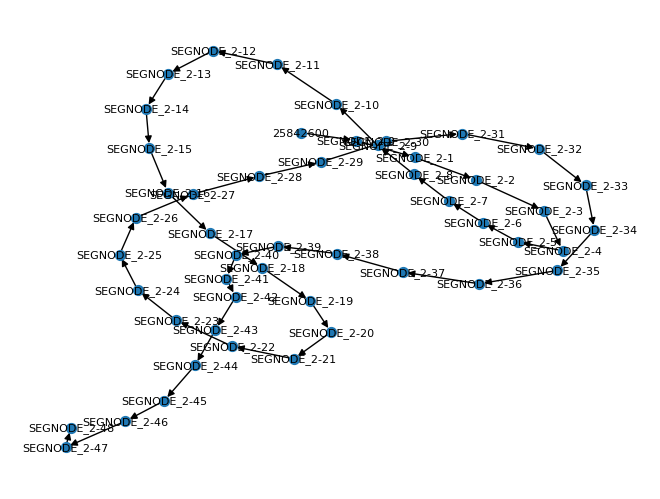

In [135]:
import matplotlib.pyplot as plt

subgraph = GRAPH_cumulative_segmentation.subgraph(list(GRAPH_cumulative_segmentation.nodes)[:50])  # Subgraph with 50 nodes
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.show()


In [136]:
for road, edges in cumulative_segmentation_graph.items():
    print(f"Road key: {road}")  # Print road identifier
    print(f"Edges: {edges[:5]}")  # Print first 5 edges for debugging
    break  # Stop after the first road to avoid excessive output


Road key: Ngapipi Road
Edges: [(25842600, 'SEGNODE_2-0', 0), ('SEGNODE_2-0', 'SEGNODE_2-1', 0), ('SEGNODE_2-1', 'SEGNODE_2-2', 0), ('SEGNODE_2-2', 'SEGNODE_2-3', 0), ('SEGNODE_2-3', 'SEGNODE_2-4', 0)]


In [167]:
Segment_gdf

,geometry,seg_id,seg_uid,seg_length,osmid
0,"LINESTRING (174.80574 -36.85355, 174.80578 -36...",0,2-0,5.00,"[1265987410, 815458771, 294270597]"
1,"LINESTRING (174.80578 -36.85357, 174.80583 -36...",1,2-1,5.00,"[1265987410, 815458771, 294270597]"
2,"LINESTRING (174.80583 -36.85360, 174.80587 -36...",2,2-2,5.00,"[1265987410, 815458771, 294270597]"
3,"LINESTRING (174.80587 -36.85363, 174.80591 -36...",3,2-3,5.00,"[1265987410, 815458771, 294270597]"
4,"LINESTRING (174.80591 -36.85366, 174.80596 -36...",4,2-4,5.00,"[1265987410, 815458771, 294270597]"
...,...,...,...,...,...
2217,"LINESTRING (174.81145 -36.85503, 174.81143 -36...",0,303-0,5.00,7631942
2218,"LINESTRING (174.81143 -36.85499, 174.81140 -36...",1,303-1,5.00,7631942
2219,"LINESTRING (174.81140 -36.85495, 174.81138 -36...",2,303-2,5.00,7631942
2220,"LINESTRING (174.81138 -36.85491, 174.81135 -36...",3,303-3,5.00,7631942


In [201]:
def SegGDFToGraph(segments_gdf:gpd.GeoDataFrame):
    
    seg_graph = mp.gdf_to_nx(segments_gdf)

    seg_graph.graph['crs'] = 'EPSG:4326'

    for node in seg_graph.nodes(data=True):
        node[1]['x'] = node[0][0]
        node[1]['y'] = node[0][1]

    return seg_graph.to_undirected()

SEG_GDF_GRAPH = SegGDFToGraph(Segment_gdf)

/Applications/anaconda3/lib/python3.12/site-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [231]:
def SegGDFToGraph(segments_gdf: gpd.GeoDataFrame):
   
    seg_graph = mp.gdf_to_nx(segments_gdf)
    seg_graph.graph['crs'] = 'epsg:4326'
    
    for node in seg_graph.nodes(data=True):
        node[1]['x'] = node[0][0]
        node[1]['y'] = node[0][1]
        
    seg_graph = nx.convert_node_labels_to_integers(seg_graph)
    
    return seg_graph.to_undirected()


SEG_GDF_GRAPH = SegGDFToGraph(Segment_gdf)

/Applications/anaconda3/lib/python3.12/site-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


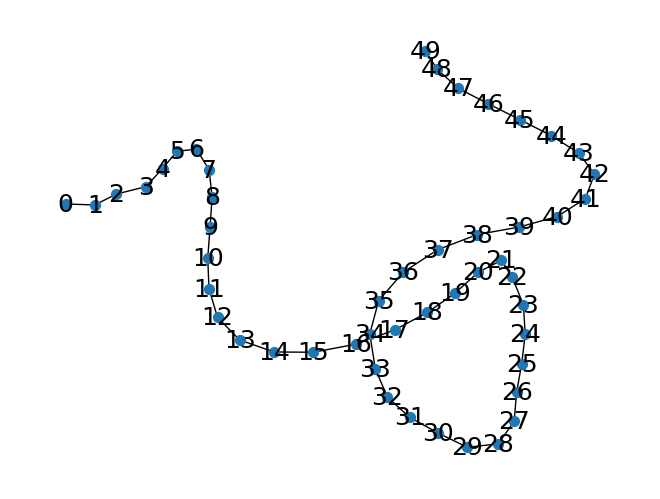

In [221]:
SEG_GDF_GRAPH_subgraph = SEG_GDF_GRAPH.subgraph(list(SEG_GDF_GRAPH.nodes)[:50])
nx.draw(SEG_GDF_GRAPH_subgraph, with_labels=True, node_size=50, font_size=18)

In [224]:
for node in SEG_GDF_GRAPH.nodes(data=True):
    print(f"Node: {node[0]}, Data: {node[1]}")


Node: 0, Data: {'x': 174.8057371, 'y': -36.8535472}
Node: 1, Data: {'x': 174.80578154257856, 'y': -36.853574720398285}
Node: 2, Data: {'x': 174.80582598515713, 'y': -36.85360224079657}
Node: 3, Data: {'x': 174.80587042773573, 'y': -36.85362976119485}
Node: 4, Data: {'x': 174.8059148703143, 'y': -36.85365728159314}
Node: 5, Data: {'x': 174.80595931289287, 'y': -36.85368480199142}
Node: 6, Data: {'x': 174.80600375547144, 'y': -36.853712322389704}
Node: 7, Data: {'x': 174.80604819805, 'y': -36.85373984278799}
Node: 8, Data: {'x': 174.8060926406286, 'y': -36.85376736318627}
Node: 9, Data: {'x': 174.8061370832072, 'y': -36.853794883584555}
Node: 10, Data: {'x': 174.8061815257858, 'y': -36.853822403982846}
Node: 11, Data: {'x': 174.80622596836437, 'y': -36.85384992438113}
Node: 12, Data: {'x': 174.80627041094294, 'y': -36.853877444779414}
Node: 13, Data: {'x': 174.8063148535215, 'y': -36.8539049651777}
Node: 14, Data: {'x': 174.80635929610008, 'y': -36.85393248557598}
Node: 15, Data: {'x': 1

In [232]:
def GetSegsAlongTracks(tracks: dict, graph: nx.Graph, max_pathlength: int = 10, remove_duplicates: bool = True,
                       debug: bool = True, filter_isolate_branches: bool = True):
    track_segs = defaultdict(dict)

    # Reload the ox module to ensure any updates are reflected
    import importlib
    importlib.reload(ox)
    
    for filename, track in tracks.items():
        # Extract coordinates from the 'filter_xy_tuple' or 'match_xy_tuple'
        # Assuming you want to use 'filter_xy_tuple'
        coords = track['match_xy_tuple']
        
        # Get nearest nodes for each point in the track
        nn = [ox.nearest_nodes(graph, x, y) for x, y in coords]  # Extract x and y from each tuple
        
        all_sps = []
        end_points = []
        for i, n in enumerate(nn):
            if 0 < i < len(nn) - 1:
                try:
                    sp = nx.shortest_path(graph, n, nn[i + 1])
                    if len(sp) <= max_pathlength:
                        all_sps.extend(sp)
                    else:
                        end_points.append(nn[i + 1])
                except nx.NetworkXNoPath:
                    if debug:
                        print(f'Path could not be found between nodes {n} and {nn[i + 1]}')

        # Remove duplicated nodes in paths
        if remove_duplicates:
            all_sps = list(dict.fromkeys(all_sps))

        track_segs[filename]['sp_list'] = all_sps
        track_segs[filename]['sp_graph'] = nx.MultiGraph(graph.subgraph(all_sps))
        track_segs[filename]['end_points'] = end_points

        if filter_isolate_branches:
            nodes_to_rm = []
            for u, v, data in list(track_segs[filename]['sp_graph'].edges(data=True)):
                if track_segs[filename]['sp_graph'].degree(u) == 1:
                    if track_segs[filename]['sp_graph'].degree(v) > 2:
                        nodes_to_rm.append(u)

                if track_segs[filename]['sp_graph'].degree(v) == 1:
                    if track_segs[filename]['sp_graph'].degree(u) > 2:
                        nodes_to_rm.append(v)

            track_segs[filename]['sp_graph'].remove_nodes_from(nodes_to_rm)

    return track_segs


segments_along_track = GetSegsAlongTracks(ngapipi_data, SEG_GDF_GRAPH)


Path could not be found between nodes 1738 and 0
Path could not be found between nodes 0 and 1748
Path could not be found between nodes 1748 and 44


In [227]:
segments_along_track

defaultdict(dict,
            {'track_id': {'sp_list': [1740, 1739, 1738],
              'sp_graph': <networkx.classes.multigraph.MultiGraph at 0x14bd7a7b0>,
              'end_points': [1740, 30]}})

In [228]:
type(segments_along_track)

collections.defaultdict

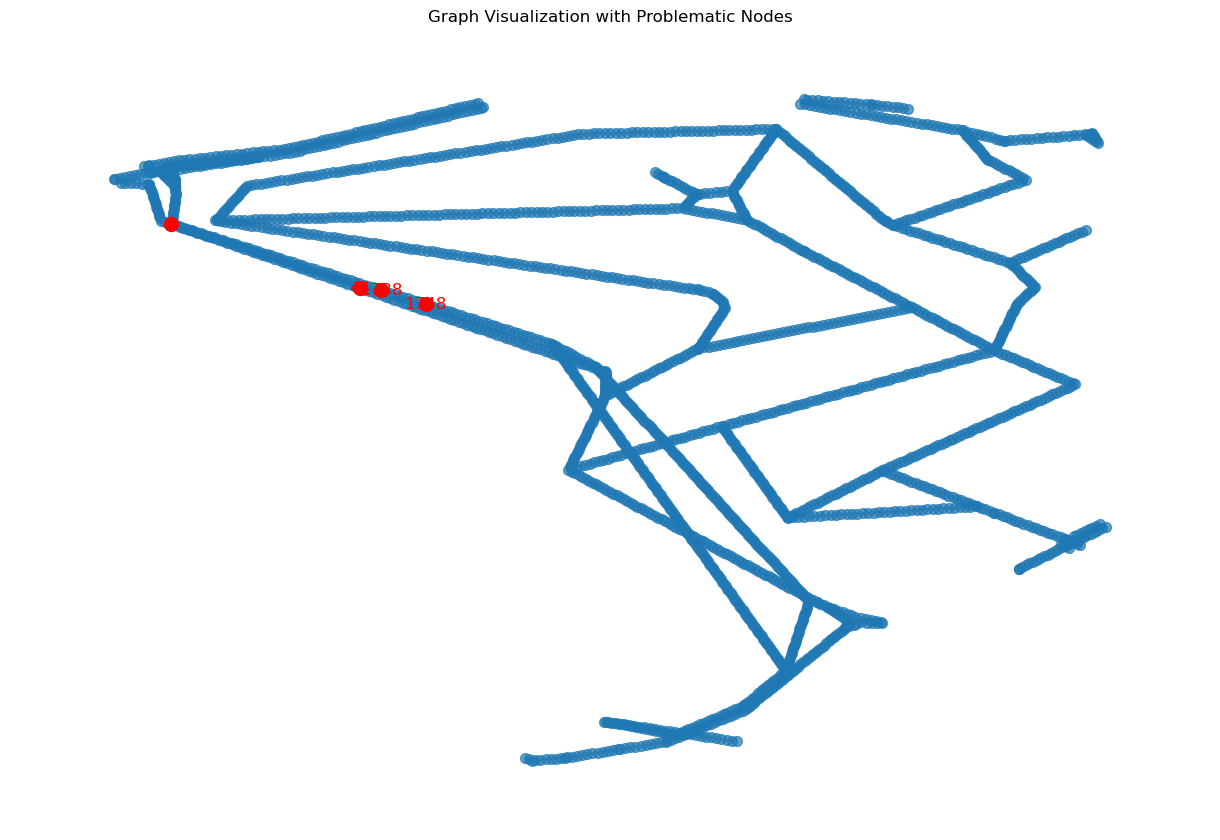

In [240]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph_with_problem_nodes(graph, problem_nodes):
    plt.figure(figsize=(12, 8))

    # Get positions (use x, y attributes if available)
    pos = {node: (data['x'], data['y']) for node, data in graph.nodes(data=True)}

    # Draw the graph
    nx.draw(graph, pos, node_size=50, edge_color='gray', alpha=0.7, with_labels=False)

    # Highlight problem nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=problem_nodes, node_color='red', node_size=100)
    nx.draw_networkx_labels(graph, pos, labels={n: str(n) for n in problem_nodes}, font_size=12, font_color='red')

    plt.title("Graph Visualization with Problematic Nodes")
    plt.show()

# Define the nodes that failed to connect
problem_nodes = [1738, 0, 1748, 44]  # Add more if needed

# Call the function
plot_graph_with_problem_nodes(SEG_GDF_GRAPH, problem_nodes)


In [241]:
import networkx as nx

# Get all connected components as a list of sets
components = list(nx.connected_components(SEG_GDF_GRAPH))

# Print the number of components
print(f"Number of connected components: {len(components)}")

# Print the size of each component
component_sizes = [len(comp) for comp in components]
print(f"Sizes of connected components: {component_sizes}")



Number of connected components: 8
Sizes of connected components: [1523, 98, 481, 10, 70, 22, 3, 8]


In [242]:
# Define your problematic nodes
problem_nodes = {1738, 0, 1748, 44}

# Map each problem node to its connected component
problem_components = {
    node: next((i for i, comp in enumerate(components) if node in comp), None)
    for node in problem_nodes
}

print("Problem Node Components:", problem_components)


Problem Node Components: {0: 0, 1738: 2, 1748: 2, 44: 0}


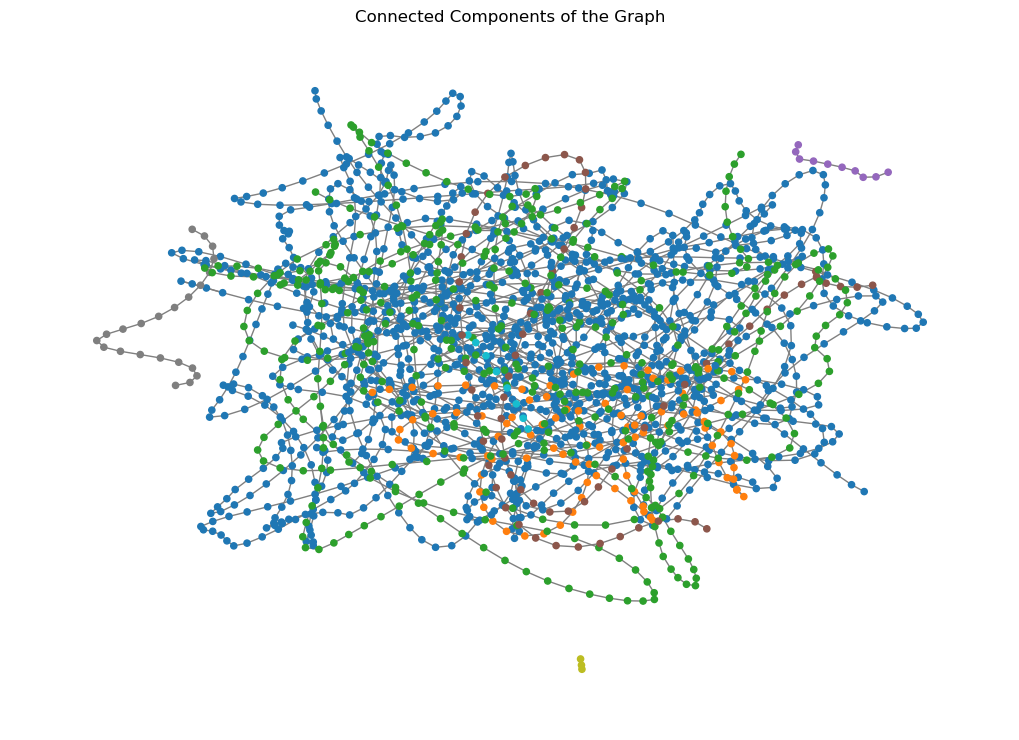

In [243]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a color map for different components
components = list(nx.connected_components(SEG_GDF_GRAPH))
color_map = {node: i for i, comp in enumerate(components) for node in comp}

# Draw the graph
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(SEG_GDF_GRAPH, seed=42)  # Layout for visualization
nx.draw(
    SEG_GDF_GRAPH, pos, 
    node_color=[color_map[n] for n in SEG_GDF_GRAPH.nodes()], 
    cmap=plt.cm.tab10, node_size=20, edge_color="gray", with_labels=False
)

plt.title("Connected Components of the Graph")
plt.show()


In [244]:
import networkx as nx

# Find which component each node belongs to
components = list(nx.connected_components(SEG_GDF_GRAPH))
node_to_component = {node: i for i, comp in enumerate(components) for node in comp}

# Check if two nodes can be connected
def can_connect(n1, n2):
    return node_to_component.get(n1) == node_to_component.get(n2)

print("Can 1738 and 0 be connected?", can_connect(1738, 0))  # Expected: False
print("Can 1748 and 44 be connected?", can_connect(1748, 44))  # Expected: False


Can 1738 and 0 be connected? False
Can 1748 and 44 be connected? False


In [246]:
list(nx.isolates(SEG_GDF_GRAPH))

[]

In [247]:
for node in [0, 1738, 1748, 44]:
    print(f"Node {node}:")
    print("Neighbors:", list(SEG_GDF_GRAPH.neighbors(node)))
    print("Position:", SEG_GDF_GRAPH.nodes[node])
    print()


Node 0:
Neighbors: [1, 114]
Position: {'x': 174.8057371, 'y': -36.8535472}

Node 1738:
Neighbors: [1737, 1739]
Position: {'x': 174.8079130954641, 'y': -36.85479652710067}

Node 1748:
Neighbors: [1747, 1749]
Position: {'x': 174.8083700345569, 'y': -36.85505827252081}

Node 44:
Neighbors: [43, 45]
Position: {'x': 174.80769257345767, 'y': -36.85475809752454}



In [260]:
def TopologicCumulativeSegmentation(graph, distance_args, segment_length, edgegroup_id='edgegroup', order_attribute='order'):
    # first step: create groups of edges from topological continuity
    #   every time an edge is intersected with another, end a segment
    #   this is very similar to cumulative segment
    #       but there is no road name/attribution grouping the edge groups
    w_graph = copy.deepcopy(graph)
    processed_edges = []
    groups = defaultdict(dict)
    edgegroup_index = 0
    # for all nodes in the source graph
    for node in w_graph.nodes():
        # if the node is an intersection
        if w_graph.degree(node) > 2:
            # get all edges from the intersection node
            for edge in w_graph.edges(node):
                # save current set if traverse has already taken place
                if edgegroup_index > 0:
                    for e in cur_set:
                        w_graph[e[0]][e[1]][0][edgegroup_id] = edgegroup_index

                cur_set = []
                # if the edge has not already been processed
                if edge not in processed_edges:
                    # traverse here
                    traverse_ended = False
                    n1 = node
                    cur_edge = edge
                    while not traverse_ended:
                        # get node not connected to previous edge
                        n2 = cur_edge[0] if cur_edge[0] != n1 else cur_edge[1]
                        # end traverse if the edge terminates or if there is an intersection
                        if 1 < w_graph.degree(n2) < 3:
                            cur_set.append(cur_edge)
                            processed_edges.append(cur_edge)
                            n2_edges = list(w_graph.edges(n2))
                            if sorted(n2_edges[0]) == sorted(cur_edge):  # have to use sorted to make sure they are identical
                                cur_edge = n2_edges[1]
                            else:
                                cur_edge = n2_edges[0]
                            n1 = n2
                        else:
                            cur_set.append(cur_edge)
                            processed_edges.append(cur_edge)
                            groups[edgegroup_index] = cur_set
                            traverse_ended = True
                            edgegroup_index += 1
                        
                    processed_edges.append(edge)
    
    # some edges will not be processed from the loop above
    #   this is because there can be sets of edges that are not connected to other roads,
    #   such that there will never be a node with degree of 2 along the set

    # this is a bit silly. I think there is some kind of list logic that does this for me
    # save unprocessed edges
    unprocessed_edges = []
    for u, v, data in w_graph.edges(data=True):
        if edgegroup_id not in data:
            unprocessed_edges.append((u, v, 0))

    # build graph from unprocessed edges, then order by connected components
    #   isolated edges will not be connected to one another, so can build an edgegroup based on this
    unprocessed_graph = nx.MultiDiGraph(nx.edge_subgraph(w_graph, unprocessed_edges)).to_undirected()
    for con in nx.connected_components(unprocessed_graph):
        con_graph = nx.MultiDiGraph(unprocessed_graph.subgraph(con)).to_undirected()
        cur_set = []
        for u, v in con_graph.edges():
            w_graph[u][v][0][edgegroup_id] = edgegroup_index
            cur_set.append((u, v))
        groups[edgegroup_index] = cur_set

        edgegroup_index += 1

    # order edges in groups
    edges_withorder = defaultdict(dict)
    for group, edges in groups.items():
        # get graph of edgegroup
        edges_withk = [(u, v, 0) for u, v in edges]
        edgegroup_graph = nx.MultiDiGraph(w_graph.edge_subgraph(edges_withk).copy()).to_undirected()

        term_nodes = GetTerminatingNodes(edgegroup_graph)
        # use northermost if no terminating nodes
        #   should this be part of the getterminatingnodes function?
        if len(term_nodes) == 0:
            source = sorted(list(edgegroup_graph.nodes(data=True)), key=lambda n: n[1]['y'], reverse=True)[0]
        else:
            source = term_nodes[0]

        # do dfs, assign order
        edge_order = nx.edge_dfs(edgegroup_graph, source=source[0])
        edge_labels = [(edge, number) for number, edge in enumerate(edge_order)]
        for edge, number in edge_labels:
            w_graph[edge[0]][edge[1]][0][order_attribute] = number

        # get data so we have new order attribute
        edges_withdata = []
        for u, v in edges:
            data = w_graph[u][v][0]
            edges_withdata.append((u, v, 0, data))
        edges_withdata.sort(key=lambda e:e[3][order_attribute], reverse=False)

        edges_withorder[group] = edges_withdata

    # second step: segment by group
    #   this is similar, but notably different from a named cumulative segmentation
    #   there is no attribute sharing between groups, for example
    #   the u/v orientation code is slightly different
    #       although I don't think it needs to be. this could all be 1-3 functions, perhaps an object
    #       job for future me. it works at least

    # assign way number
    for i, (u, v, data) in enumerate(w_graph.edges(data=True)):
        data['way_number'] = i

    nodes = w_graph.nodes(data=True)
    # for each group of odges
    for group_id, cur_group in edges_withorder.items():

        seg_order = 0
        residual_len = 0
        residual = False
        seg_num = 0
        seg_pos_index = 0
        first_edge = True
        # for each edge in group
        for i, (u, v, k, data) in enumerate(cur_group):
            
            u_x, u_y = nodes[u]['x'], nodes[u]['y']
            v_x, v_y = nodes[v]['x'], nodes[v]['y']
                
            if residual:
                if residual_x == u_x:
                    x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')
                else:
                    x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
            else:

                if first_edge:
                    first_edge = False
                    if len(cur_group) > 1:
                        next_edge = cur_group[i + 1]
                        next_u, next_v = next_edge[0], next_edge[1]
                        
                        # a notable difference from the original cumulative segmentation
                        # here i am checking u against v
                        # the orientation is also different under the conditions
                        # I have no idea why this works...
                        if next_u == v:  
                            x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')
                        else:
                            x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
                    # if there is only one edge in the group
                    else:
                        # take northernmost node
                        x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'n')   
                else:
                    # if last edge, take direction from previous
                    if i == len(cur_group) - 1:
                        # go from previous connection
                        prev_edge = cur_group[i - 1]
                        prev_u, prev_v = prev_edge[0], prev_edge[1]

                        if prev_u == u:
                            x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')
                        else:
                            x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
                    # if not last edge, take direction from next 
                    #   this feels VERY redundant. I should just take direction from last every time except first edge?
                    else:
                        next_edge = cur_group[i + 1]
                        next_u, next_v = next_edge[0], next_edge[1]
                        
                        if next_u == u:
                            x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'vu')
                        else:
                            x1, x2, y1, y2 = UVtoXYs(u_x, u_y, v_x, v_y, 'uv')

                seg_num += 1
                seg_pos_index = 0
                seg_order += 1
                cur_seg_len = 0
            
            segments = []

            d = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)
    
            already_done = False
            # if there is residual distance to include from last edge
            if residual:
                # if the length of the edge is greater than the residual length
                if d < residual_len:
                    
                    # save segment info
                    cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, group_id, data['order'], method='topo')
                    segments.append([(x1, y1), (x2, y2), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, group_id, d])

                    # extras
                    residual = True
                    residual_x, residual_y = x2, y2
                    residual_len = round(residual_len - d, distance_args['decimals'])
                    already_done = True
                    seg_pos_index += 1

                # if the length of the edge is less than the residual length
                else:
                    # will this work if the residual is longer than the u->v distance?
                    # no - there will have to be 'nested'/cumulative residual calculations
                    t = residual_len / d

                    end_x, end_y = (((1 - t) * x1 + t * x2), ((1 - t) * y1 + t * y2))
                    cur_seg_len = DistanceBetweenXYPairs((x1, y1), (end_x, end_y), distance_args)
                    
                    # seg info
                    cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, group_id, data['order'], method='topo')
                    segments.append([(x1, y1), (end_x, end_y), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, group_id, cur_seg_len])

                    # reset
                    d = d - cur_seg_len
                    x1, y1 = end_x, end_y
                    residual = False
                    seg_num += 1
                    seg_pos_index = 0
                    seg_order += 1
                    #print(d, cur_seg_len)

            # while the remaining distance in the edge is longer than the segment length
            while d > segment_length:
            
                t = segment_length / d
                end_x, end_y = (((1 - t) * x1 + t * x2), ((1 - t) * y1 + t * y2))
                cur_seg_len = DistanceBetweenXYPairs((x1, y1), (end_x, end_y), distance_args)

                # save segment info
                cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, group_id, data['order'], method='topo')
                segments.append([(x1, y1), (end_x, end_y), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, group_id, cur_seg_len])
                
                # reset segment values
                seg_num += 1
                #seg_pos_index = 0
                d = DistanceBetweenXYPairs((x2, y2), (end_x, end_y), distance_args)
                x1, y1 = end_x, end_y
                seg_order += 1
                
            else:
                if not already_done:
                    cur_seg_len = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)
                
                    # save segment info
                    cur_seg_id, cur_seg_uid, cur_seg_grp = GetSegIDs(data['way_number'], seg_num, seg_pos_index, group_id, data['order'], method='topo')
                    segments.append([(x1, y1), (x2, y2), cur_seg_id, cur_seg_uid, cur_seg_grp, seg_order, group_id, cur_seg_len])
                    
                    # extras
                    residual = True
                    seg_pos_index += 1
                    residual_len = round(segment_length - cur_seg_len, distance_args['decimals'])
                    residual_x, residual_y = x2, y2

            data['segments'] = segments
            data['edge_id'] = None
            data['direction'] = None
            data['order_on_road'] = data['order']

    return w_graph


segment_length = 5

topological = TopologicCumulativeSegmentation(Ordered_seg_graph, distance_args_defined, segment_length, edgegroup_id='edgegroup', order_attribute='order')

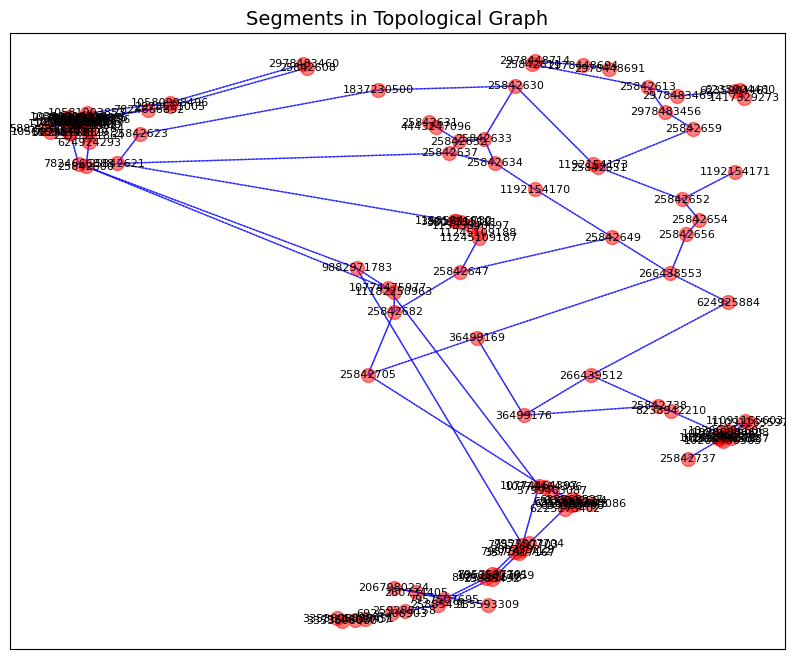

In [271]:
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import LineString

# Create a plot for the graph
plt.figure(figsize=(10, 8))

# Extract and plot the segments from the edges
for u, v, data in G.edges(data=True):
    if 'segments' in data:
        # Loop over the list of segments in each edge
        for segment in data['segments']:
            # Each segment is a tuple (start_point, end_point, segment_id, etc.)
            start_point, end_point, *other_info = segment
            
            # Get the coordinates for the start and end points of the segment
            start_x, start_y = start_point
            end_x, end_y = end_point
            
            # Plot the segment as a line
            plt.plot([start_x, end_x], [start_y, end_y], color='blue', linewidth=1, alpha=0.7)

# Optionally, plot the nodes if needed (optional)
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}  # Node positions
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='red', alpha=0.5)

# Optionally add node labels
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Add title
plt.title("Segments in Topological Graph", fontsize=14)

# Show the plot
plt.show()


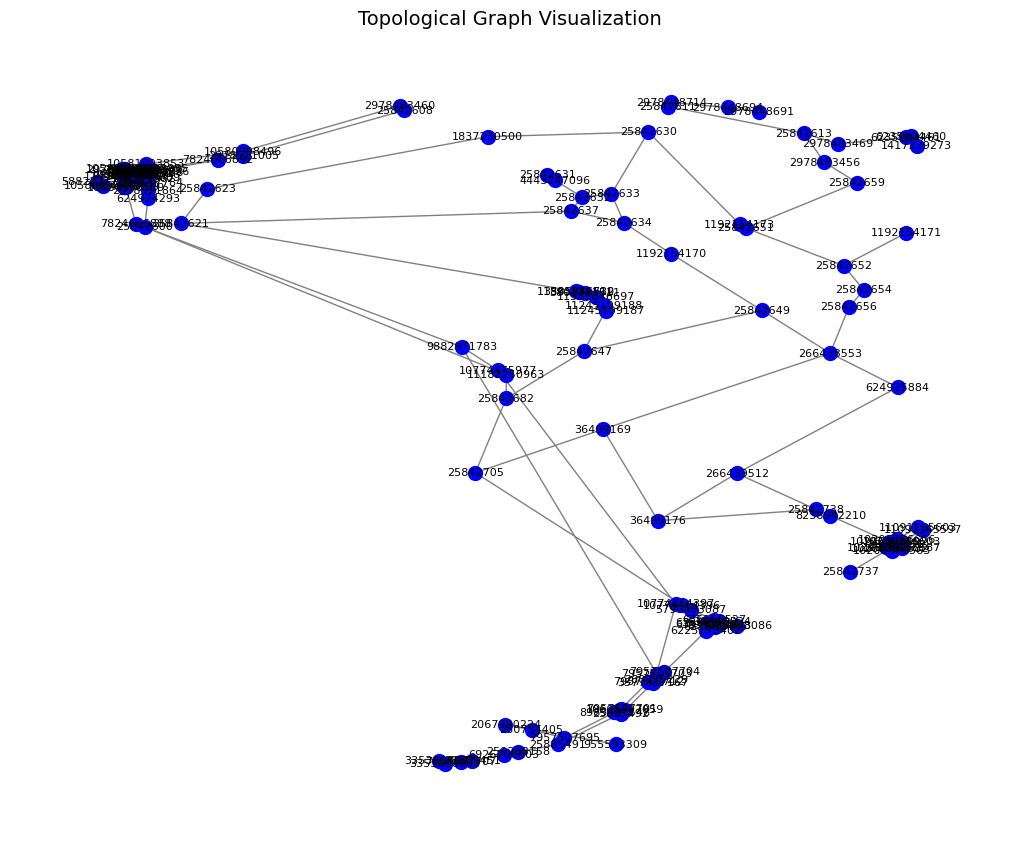

In [269]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a NetworkX graph from your topological data
# You can use Ordered_seg_graph or any graph you are working with
G = topological

# Create a plot for the graph
plt.figure(figsize=(10, 8))

# Plot the graph
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}  # Position the nodes based on their x, y coordinates
nx.draw(G, pos, with_labels=True, node_size=100, node_color='blue', edge_color='gray', font_size=8, font_color='black')

# Add labels (optional) and title
plt.title("Topological Graph Visualization", fontsize=14)

# Show the plot
plt.show()


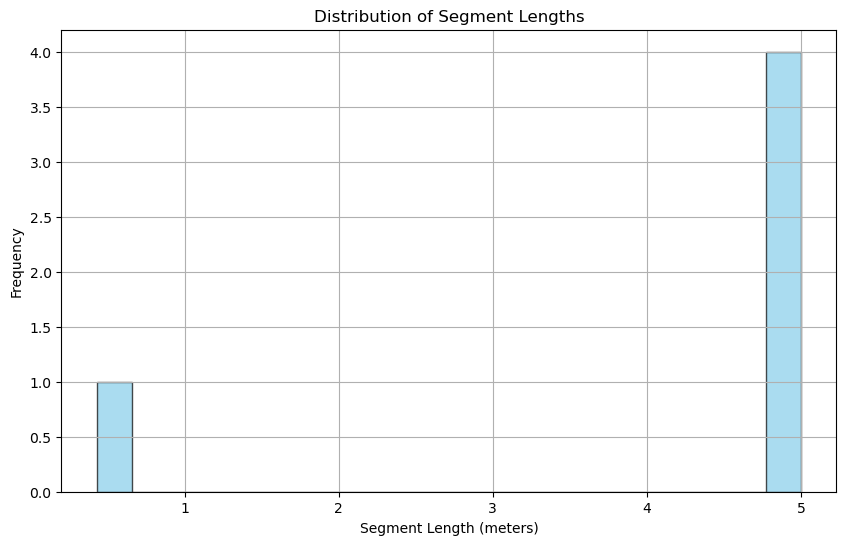

In [276]:
import matplotlib.pyplot as plt

# Assuming 'segments' is a list containing the segment data
# Extracting segment lengths from the segments data
segment_lengths = [segment[4] for segment in segments]

# Plotting the segment lengths
plt.figure(figsize=(10, 6))
plt.hist(segment_lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.title("Distribution of Segment Lengths")
plt.xlabel("Segment Length (meters)")
plt.ylabel("Frequency")
plt.grid(True)

# Show the plot
plt.show()



In [ ]:
def GetGraph(graph_path, segment_length, segment_method, area_name, distance_args, include_footpaths, debug, 
            way_group_attribute, edge_rmattr=False):
    
    # linestring gdf path is a function of the original graph path, not created in config. perhaps that should be changed
    graph_ls_dir = graph_path.split('.')[0] + '_multipart.gpkg'

    if not os.path.exists(graph_path):
        filter = utils.bike_withfootpaths if include_footpaths else utils.custom_bikefilter
        #bbox = utils.GetBboxFromTracks(matched_tracks, name='domain AOI', xy_col=f'{FILTER_PREFIX}xy_tuple')
        if area_name == 'domain':
            bbox = utils.domain_bbox
        elif area_name == 'innercentral':
            bbox = utils.innercentral_bbox
        elif area_name == 'allakl':
            bbox = utils.aklregion_bbox

        graph = OSMDownloader(bbox, filter=filter, debug=debug)

        if segment_method == 'edge':
            # filter, direct, segment graph
            if edge_rmattr:
                graph_withattribution = RemoveEdgesWithoutAttribute(graph, way_group_attribute, debug=debug)
                graph_withsegdirection = GetEdgeDirections(graph_withattribution, debug=debug)
                graph_segmented = SegmentEdges(graph_withsegdirection, segment_length,
                                            'interpolate', debug=debug, distance_args=distance_args)
                segment_graph = GraphFromSegments(graph_segmented, debug=debug)
                segment_graph_ordered = OrderSegmentGraph(segment_graph, group_attribute=way_group_attribute, debug=debug)
                segments_gdf = ox.graph_to_gdfs(segment_graph_ordered, nodes=False)

            else:
                graph_withsegdirection = GetEdgeDirections(graph, debug=debug)
                graph_segmented = SegmentEdges(graph_withsegdirection, segment_length,
                                            'interpolate', debug=debug, distance_args=distance_args)
                segment_graph = GraphFromSegments(graph_segmented, debug=debug)
                segments_gdf = ox.graph_to_gdfs(segment_graph, nodes=False)
            
            # create and order new graph based on segments on previous graph
            

           
            # convert graph to gdf
            

        elif segment_method == 'namedtopologic':

            graph_ordered = OrderSegmentGraph(graph, out_attribute='order', add_numbering=True)

            # for some reason some edges are not being assigned a custom_ref
            #   very minor (2 edges in innercentral bbox of 34800 edges)
            #   still something to consider. worth noting those 2 edges had identical osmids
            
            graph_ordered_clean = RemoveEdgesWithoutAttribute(graph_ordered, 'custom_ref')

            # segment cumulatively, save as gdf
            graph_seg_name = CumulativeSegmentation(graph_ordered_clean, 'custom_ref', segment_length, distance_args)
            
            # this works! pretty cool. read code_notes on 12/06/23 for bug description
            graph_seg_namedtopo = TopologicCumulativeSegmentation(graph_seg_name, distance_args, segment_length)
            segments_gdf = SegGDFFromGraph(graph_seg_namedtopo, segment_length)
        
        elif segment_method == 'topologic':
            graph_segmented = TopologicCumulativeSegmentation(graph, distance_args, segment_length)
            segments_gdf = SegGDFFromGraph(graph_segmented, segment_length)

        segments_gdf.to_file(graph_path, driver='GPKG', crs='EPSG:4326')

    else:    
        segments_gdf = gpd.read_file(graph_path).to_crs('EPSG:4326')

    # handle linestring creation. does not apply to edge segmentation method
    if segment_method != 'edge':
        if not os.path.exists(graph_ls_dir):
            segments_ls_gdf = utils.LineGDFtoLineStringGDF(segments_gdf, segment_method=segment_method)
            segments_ls_gdf.to_file(graph_ls_dir, driver='GPKG', crs='EPSG:4326')
        else:
            segments_ls_gdf = gpd.read_file(graph_ls_dir).to_crs('EPSG:4326')

        return segments_gdf, segments_ls_gdf

    # edge segmentation returns None for linestring gdf
    else:
        return segments_gdf, None

In [ ]:
# get the segments along a ride, given a matched GPX and a graph of the entire network
def GetRideSegsGDF(matched_gdf, matched_filename, network_graph, seg_multi_gdf, 
                   max_pathlength=40, group_attr='seg_group', multipart=True):
     
    track_segs = GetSegsAlongTracks({matched_filename: matched_gdf}, network_graph, max_pathlength)

    track_segs_graph = track_segs[matched_filename]['sp_graph']  # get shortest path graph

    # extract ids of segments passed along track, using the data of the shortest path graph
    track_seg_ids = [i[2][group_attr] for i in track_segs_graph.edges(data=True)]

    # get a geodataframe of the segments passed along the track
    track_segs_mp = seg_multi_gdf[seg_multi_gdf[group_attr].isin(track_seg_ids)]

    return track_segs_mp.reset_index(drop=True)

